# Class Activty 9: Mixture Model Residual Quiz (10 minutes)

1. Describe what a sample from a ***Dirichlet Process Mixture distribution*** is and how to produce it.
<br>*Hint: how does a* ***Dirichlet Process Mixture distribution*** *sample differ from a*  ***Dirichlet Process*** sample?

2. How can the following be updated specify a ***nonparametric*** residual distribution for a linear regression model?

```python
with pm.Model(coords={"cluster": range(k)}) as model:
    μ = pm.Normal("μ", mu=mus, sigma=sigmas, initval=initvals, dims="cluster",
                  transform=pm.distributions.transforms.univariate_ordered) 
    σ = pm.HalfNormal("σ", sigma=1, dims="cluster")
    weights = pm.Dirichlet("w", 2*np.ones(k), dims="cluster")
    v = pm.Categorical('v', p=weights, size=n) #v = pm.Multinomial('v', n=1, p=p, size=n)
    pm.Normal('y', mu=μ[v], sigma=σ[v], observed=y)
    #pm.NormalMixture("y", w=weights, mu=μ, sigma=σ, observed=y)
```

3. Could it be further changed to provide a fully ***nonparametric*** model for $E[y]=f(x)$ if $f$ is a monotonical function increasing from a minimum value of $\displaystyle \lim_{x\rightarrow -\infty} f(x) = 0$ to a maximum value of $\displaystyle \lim_{x\rightarrow \infty} f(x) = 1$?

# Class Activty 9: Mixture Model Residual Reivew (10 minutes)

1. A ***Dirichlet Process*** sample is a discrete distribution while a sample from a ***Dirichlet Process Mixture distribution*** is a continuous distribution (which is a sampled mixture model distribution). 

$$
\scriptsize
\begin{align*}
\theta_i \sim{}& p & \theta_i \sim{}& p = \textstyle \sum_{j=1}^\infty w_j \delta_{{y}_{j}} \quad\quad\quad\quad\;\;\, \color{blue}{f_{\theta_i} = \mathcal N(\theta_i, \sigma=0.3) \sim DPM(\alpha, p_0, N(\cdot, \sigma=0.3))} \\
p \sim{}& DP({\alpha, p_0)}  &  w_j ={}& \beta_j  \textstyle \prod_{k=1}^{j-1}(1-\beta_k) \quad y_j \sim{} \mathcal N(0,1)  \quad\, \displaystyle \color{blue}{\underset{\sim DMP}{f =} \int f_{\theta_i} p(\theta_i)d\theta_i \approx \sum_{i=1}^n w_i \mathcal N(y_i, \sigma=0.3)} \\
& 2, \mathcal N(0,1) &  \beta_j \sim{}& \text{Beta}(\color{gray}{\alpha\text{ [for Beta]}}=1,\beta=\alpha=2\color{gray}{\text{ [from DP]}})
&& 
\end{align*}$$

2. How can the following be updated specify a ***nonparametric*** residual distribution for a linear regression model?

```python
with pm.Model(coords={"cluster": range(k)}) as model:
    μ = pm.Normal("μ", mu=mus, sigma=sigmas, initval=initvals, dims="cluster",
                  transform=pm.distributions.transforms.univariate_ordered) 
    σ = pm.HalfNormal("σ", sigma=1, dims="cluster")
    weights = pm.Dirichlet("w", 2*np.ones(k), dims="cluster")
    v = pm.Categorical('v', p=weights, size=n) #v = pm.Multinomial('v', n=1, p=p, size=n)
    β = pm.Normal("β", mu=beta_mus, sigma=beta_sigmas, ims=q)
    pm.Normal('y', mu=μ[v]+X@β, sigma=σ[v], observed=y)
```

3. Could it be further changed to provide a fully ***nonparametric*** model for $E[y]=f(x)$ if $f$ is a monotonical function increasing from a minimum value of $\displaystyle \lim_{x\rightarrow -\infty} f(x) = 0$ to a maximum value of $\displaystyle \lim_{x\rightarrow \infty} f(x) = 1$?

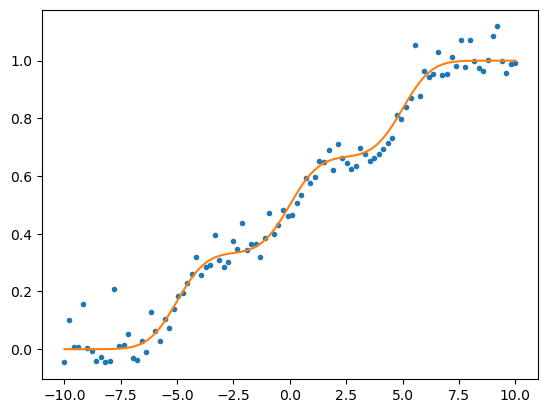

In [7]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
n=100
x = np.linspace(-10,10,n)
y_true = (stats.norm(-5,1).cdf(x)+stats.norm(0,1).cdf(x)+stats.norm(5,1).cdf(x))/3
y = y_true + 0.05*(stats.gamma(1,1).rvs(n)-stats.gamma(1,1).mean())
plt.plot(x,y,'.'); plt.plot(x,y_true);

In [150]:
import pymc as pm

import pytensor.tensor as pt
def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

k = 10; mus=np.linspace(-5,5,k); sigmas=np.array(k*[1]); initvals=mus.copy()
with pm.Model(coords={"f_cluster": range(k), "e_cluster": range(k)}) as model:
    
    alpha_f = pm.Gamma("alpha_f", 1.0, 1.0); beta_f = pm.Beta("beta_f", 1.0, alpha_f, dims="f_cluster")
    w_f = pm.Deterministic("w_f", stick_breaking(beta_f), dims="f_cluster")    
    μ_f = pm.Normal("μ_f", mu=mus, sigma=sigmas, initval=initvals, dims="f_cluster",
                    transform=pm.distributions.transforms.univariate_ordered) 
    σ_f = pm.HalfNormal("σ_f", sigma=1, dims="f_cluster")
    p_f = pm.NormalMixture("p_f", w=w_f/w_f.sum(), mu=μ_f, sigma=σ_f)
    f = pm.Deterministic("f", pm.math.exp(pm.logcdf(p_f,x)))

    alpha_e = pm.Gamma("alpha_e", 1.0, 1.0); beta_e = pm.Beta("beta_e", 1.0, alpha_e, dims="e_cluster")
    w_e = pm.Deterministic("w_e", stick_breaking(beta_e), dims="e_cluster")    
    μ_e = pm.Normal("μ_e", mu=mus/50+0.05, sigma=sigmas/5, initval=initvals/50+0.05, dims="e_cluster",
                    transform=pm.distributions.transforms.univariate_ordered)  
    σ_e = pm.HalfNormal("σ_e", sigma=sigmas/5, dims="e_cluster")    
    v = pm.Categorical('v', p=w_e/w_e.sum(), size=n) #v = pm.Multinomial('v', n=1, p=p, size=n)
    pm.Normal('y', mu=μ_e[v]+f, sigma=σ_e[v], observed=y)
    #e = pm.NormalMixture("y", w=w_e, mu=μ_e, sigma=σ_e)    
    #llike = pm.Potential("llike", pm.logp(e,y-f))

with model:
    idata = pm.sample()#(tune=5000, init="advi", target_accept=0.95) 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha_f, beta_f, μ_f, σ_f, p_f, alpha_e, beta_e, μ_e, σ_e]
>CategoricalGibbsMetropolis: [v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.


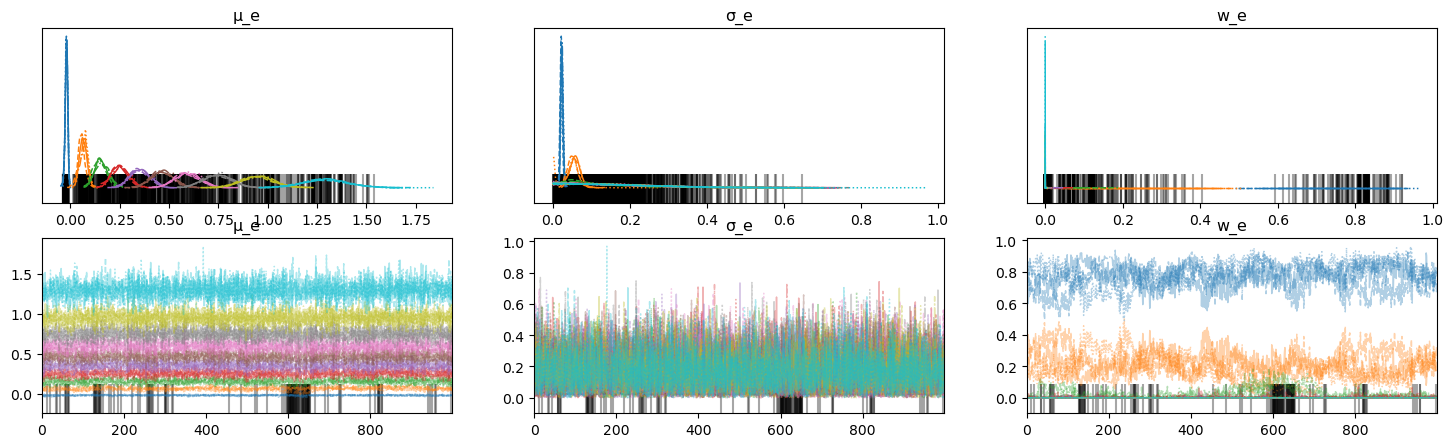

In [151]:
import arviz as az;
fig,ax = plt.subplots(2,3,figsize=(18,5)); az.plot_trace(idata, var_names=["μ_e", "σ_e", "w_e"], axes=ax.T);

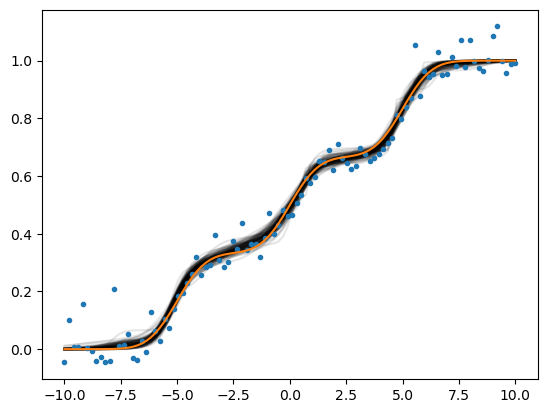

In [152]:
for i in range(100):
    plt.plot(x,idata.posterior['f'].values[0][i,:],'k', alpha=0.1)
plt.plot(x,y,'.'); plt.plot(x,y_true)    

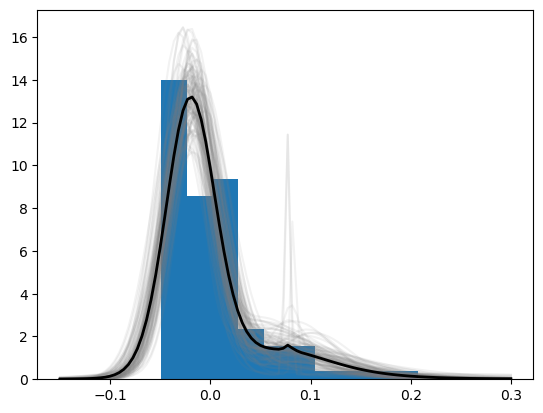

In [154]:
support=np.linspace(-0.15,0.3,100); ave_mixture=0*support; reps=100
for j in range(reps):
    
    chain,draw=np.random.choice([0,1,2,3]),np.random.choice(np.linspace(0,999,1000,dtype=int))
    
    mixture = stats.norm(idata.posterior['μ_e'][chain,draw],
                         idata.posterior['σ_e'][chain,draw]).pdf(np.array([support]*k).reshape(k,100).T)    
    mixture = (mixture*idata.posterior['w_e'][chain,draw].values).sum(axis=1)
    
    plt.plot(support, mixture, c='gray', alpha=0.1); ave_mixture += mixture/reps
plt.plot(support, ave_mixture, 'k', lw=2)
plt.hist(y-y_true, density=True);

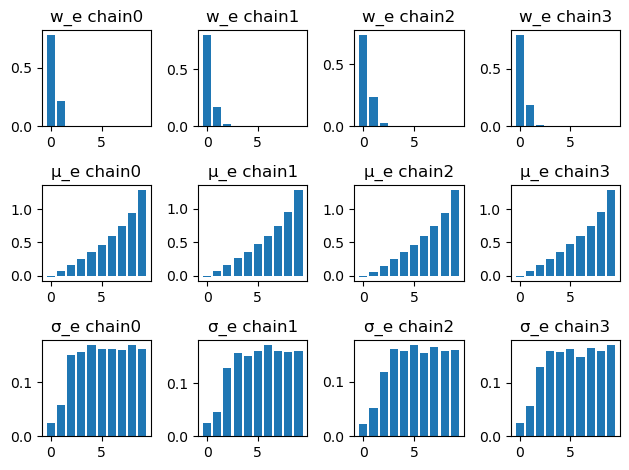

In [155]:
fig,ax = plt.subplots(3,4)
for c in range(4):
    ax[0,c].bar(height=idata.posterior['w_e'].values[c].mean(axis=0), x=np.arange(10)); ax[0,c].set_title('w_e'+' chain'+str(c))
    ax[1,c].bar(height=idata.posterior['μ_e'].values[c].mean(axis=0), x=np.arange(10)); ax[1,c].set_title('μ_e'+' chain'+str(c))
    ax[2,c].bar(height=idata.posterior['σ_e'].values[c].mean(axis=0), x=np.arange(10)); ax[2,c].set_title('σ_e'+' chain'+str(c))
plt.tight_layout()

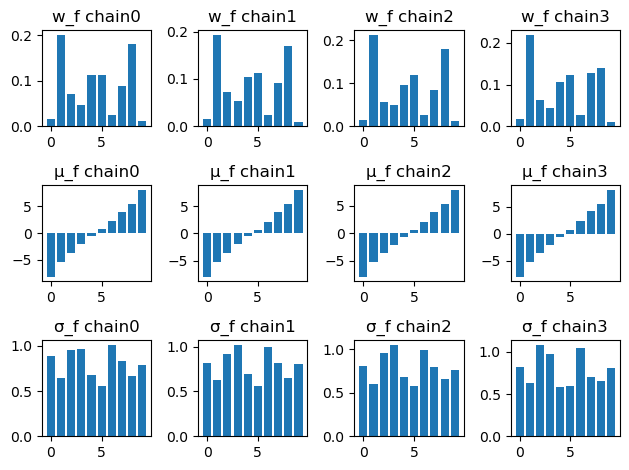

In [156]:
fig,ax = plt.subplots(3,4)
for c in range(4):
    ax[0,c].bar(height=idata.posterior['w_f'].values[c].mean(axis=0), x=np.arange(10)); ax[0,c].set_title('w_f'+' chain'+str(c))
    ax[1,c].bar(height=idata.posterior['μ_f'].values[c].mean(axis=0), x=np.arange(10)); ax[1,c].set_title('μ_f'+' chain'+str(c))
    ax[2,c].bar(height=idata.posterior['σ_f'].values[c].mean(axis=0), x=np.arange(10)); ax[2,c].set_title('σ_f'+' chain'+str(c))
plt.tight_layout()

In [4]:
import numpy as np
xx = x.eval()

In [36]:
import pymc as pm
import pytensor.tensor as pt

def normal_logp(value, mu, sigma):
    return -0.5 * ((value - mu) / sigma) ** 2 - pm.math.log(sigma) - 0.5*pm.math.log(2*np.pi)

n=5
with pm.Model() as m:
    #p(theta|x)/p(theta) = p(x|theta)p(theta)/p(x)p(theta) = p(x|theta)/p(x)
    # p(x) = int p(x,theta) dtheta = int p(x|theta)p(theta) dtheta     
    
    #mu_prior = pm.Normal('mu_prior', mu=0, sigma=1, shape=1)
    mu = pm.Normal('mu', mu=0, sigma=1, shape=1)    
    x = pm.Normal('x', mu=mu, sigma=1, shape=n)
    loglik = pm.Deterministic("loglik", normal_logp(xx,mu,1).sum())
    loglik2 = pm.Deterministic("loglik2", normal_logp(x,mu,1).sum())
    prior = pm.Deterministic("prior", normal_logp(mu,0,1))
    posterior = pm.Deterministic("posterior", normal_logp(mu,x.sum()/(n+1),1/pm.math.sqrt(n+1)))
    BR = pm.Deterministic("BR", posterior-prior)#pm.math.exp()
    # E[ Pr( BR(mu|x)<=1 | mu ) ]
    # -> E_mu[E_x[log p(x|mu) - log p(x) < 0|mu]]
    # https://stats.stackexchange.com/questions/172196/relation-between-expectation-of-ratio-and-ratio-of-expectation
    # INT INT logp(x|mu) - logp(x) x mu
    
    mu_ = pm.Normal('mu_', mu=0, sigma=1, shape=1)    
    y = pm.Normal('y', mu=mu_, sigma=1, observed=xx)
    loglik_ = pm.Deterministic("loglik_", normal_logp(xx,mu_,1).sum())
    prior_ = pm.Deterministic("prior_", normal_logp(mu_,0,1))
    posterior_ = pm.Deterministic("posterior_", normal_logp(mu_,xx.sum()/(n+1),1/pm.math.sqrt(n+1)))
    BR = pm.Deterministic("BR_", posterior_-prior_)#pm.math.exp()
    
with m:
    idata = pm.sample(10000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, x, mu_]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 4 seconds.


In [39]:
def normal_logp_(value, mu, sigma):
    return -0.5 * ((value - mu) / sigma) ** 2 - np.log(sigma) - 0.5*np.log(2*np.pi)

mm=1000
px = np.zeros(mm)
for i in range(mm):
    px[i] = normal_logp_(idata.posterior['x'].values.reshape(40000,5)[i:(i+1),:], 
                         idata.posterior['mu'].values.reshape(40000,1), 1).sum(axis=1).mean()
px.mean()

-12.151907897737297

In [37]:
idata.posterior['loglik2'].values.mean()

-7.077004996084079

In [38]:
normal_logp_(idata.posterior['x'].values.reshape(40000,5), 
             idata.posterior['mu'].values.reshape(40000,1), 1).sum(axis=1).mean()

-7.077004996084079

E[ Pr( BR(mu0|x)<=1 | mu0 ) ] = int int 1_[log(p(mu|x)/p(mu))<0] p(x,mu): 0.1079


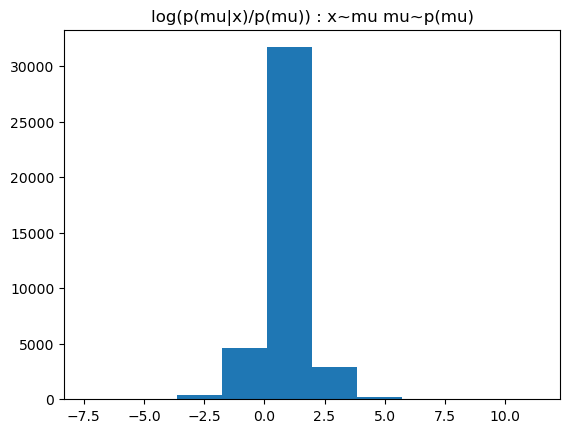

In [150]:
plt.hist(idata.posterior['BR'].values.ravel()); plt.title('log(p(mu|x)/p(mu)) : x~mu mu~p(mu)')
print('E[ Pr( BR(mu0|x)<=1 | mu0 ) ] = int int 1_[log(p(mu|x)/p(mu))<0] p(x,mu):', (idata.posterior['BR'].values.ravel()<=0).mean())

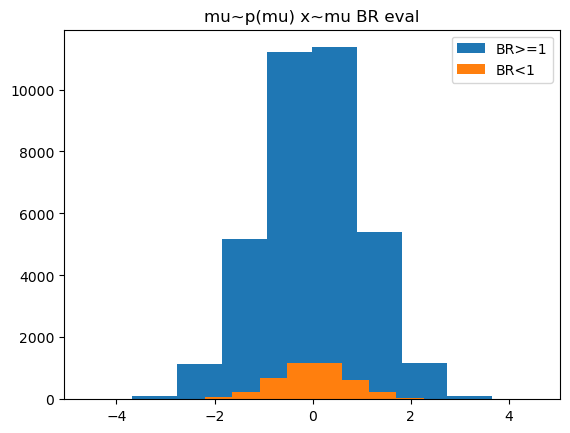

In [155]:
plt.hist(idata.posterior['mu'].values.ravel()[idata.posterior['BR'].values.ravel()>=0],alpha=1, label="BR>=1")
plt.hist(idata.posterior['mu'].values.ravel()[idata.posterior['BR'].values.ravel()<0],alpha=1, label="BR<1")
plt.legend(); plt.title("mu~p(mu) x~mu BR eval");

posterior credible level: 0.91885
0.5102984498805915 2.1157872055808533


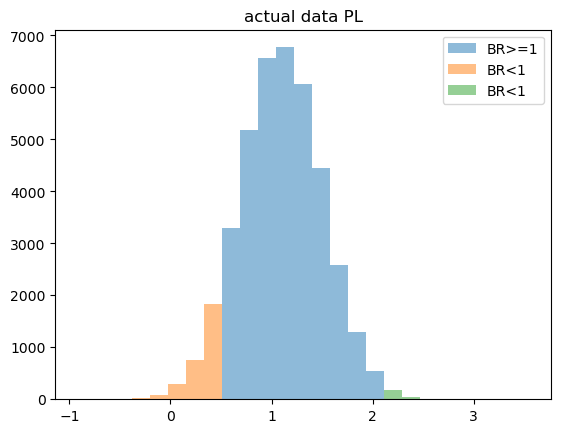

In [246]:
import numpy as np
pl = idata.posterior['mu_'].values.ravel()[idata.posterior['BR_'].values.ravel()>=0]
bins = np.linspace(pl.min(),pl.max(),10)
plt.hist(pl,bins=bins, alpha=0.5, label="BR>=1")
plt.hist(idata.posterior['mu_'].values.ravel()[idata.posterior['BR_'].values.ravel()<0],
         bins = sorted(bins[1]-(bins[1:]-bins[:-1]).cumsum()), alpha=0.5, label="BR<1")
plt.hist(idata.posterior['mu_'].values.ravel()[idata.posterior['BR_'].values.ravel()<0],
         bins = sorted(bins[-2]+(bins[1:]-bins[:-1]).cumsum()), alpha=0.5, label="BR<1")
plt.legend(); plt.title('actual data PL')
print("posterior credible level:", (idata.posterior['BR_'].values.ravel()>=0).mean())
print(pl.min(),pl.max())

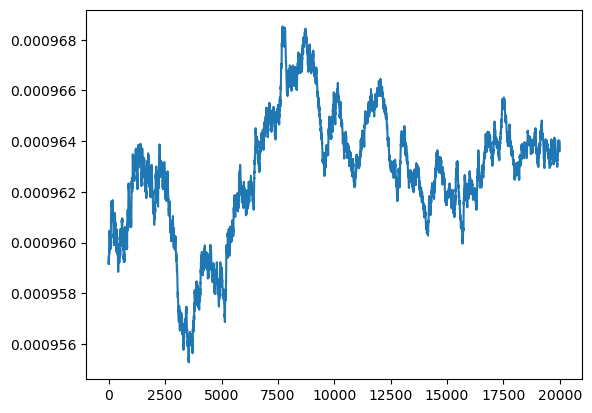

In [245]:
#p(theta|x)/p(theta)
#p(x|theta)p(theta)/[p(x)p(theta)]
#p(x|theta)/p(x)
samps=np.exp(idata.posterior['loglik'].values.ravel()).shape[0]
loglikest = np.exp(idata.posterior['loglik'].values.ravel()).cumsum()/np.arange(1,samps+1)
plt.plot(loglikest[-int(samps/2):])

posterior credible level: 0.91765
0.5126156106051787 2.1156176455365525


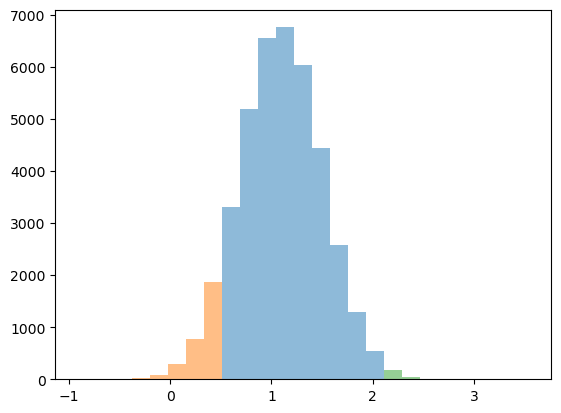

In [248]:
pl = idata.posterior['mu_'].values.ravel()[np.exp(idata.posterior['loglik_'].values.ravel()) >= np.exp(idata.posterior['loglik'].values.ravel()).mean()]
bins = np.linspace(pl.min(),pl.max(),10)
plt.hist(pl,bins=bins, alpha=0.5, label="joint>=prior/(n+1)")
impl = idata.posterior['mu_'].values.ravel()[np.exp(idata.posterior['loglik_'].values.ravel()) < np.exp(idata.posterior['loglik'].values.ravel()).mean()]
plt.hist(impl,
         bins = sorted(bins[1]-(bins[1:]-bins[:-1]).cumsum()), alpha=0.5, label="BR<1")
plt.hist(impl,
         bins = sorted(bins[-2]+(bins[1:]-bins[:-1]).cumsum()), alpha=0.5, label="BR<1")
print("posterior credible level:", (np.exp(idata.posterior['loglik_'].values.ravel()) >= np.exp(idata.posterior['loglik'].values.ravel()).mean()).mean())
print(pl.min(),pl.max())

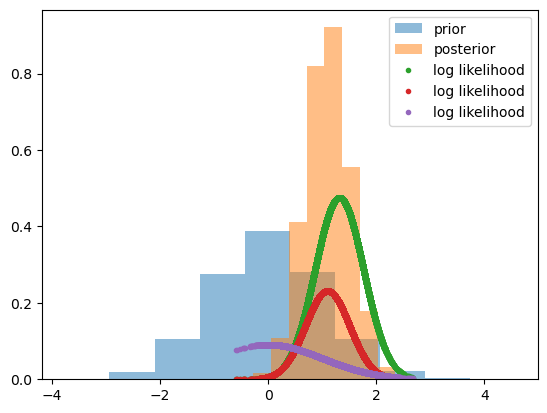

In [189]:
plt.hist(idata.posterior['mu'].values.ravel(), density=True, alpha=0.5, label='prior')
plt.hist(idata.posterior['mu_'].values.ravel(), density=True, alpha=0.5, label='posterior')
plt.plot(idata.posterior['mu_'].values.ravel(), np.exp(idata.posterior['loglik_'].values.ravel()),'.',label='log likelihood')
plt.plot(idata.posterior['mu_'].values.ravel(), np.exp(idata.posterior['joint_'].values.ravel()),'.',label='log likelihood')
plt.plot(idata.posterior['mu_'].values.ravel(), np.exp(idata.posterior['prior_'].values.ravel())/11,'.',label='log likelihood')
plt.legend();

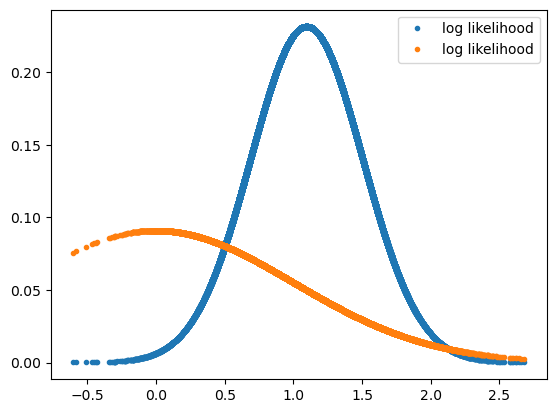

In [190]:
plt.plot(idata.posterior['mu_'].values.ravel(), np.exp(idata.posterior['joint_'].values.ravel()),'.',label='log likelihood')
plt.plot(idata.posterior['mu_'].values.ravel(), np.exp(idata.posterior['prior_'].values.ravel())/(n+1),'.',label='log likelihood')
plt.legend();

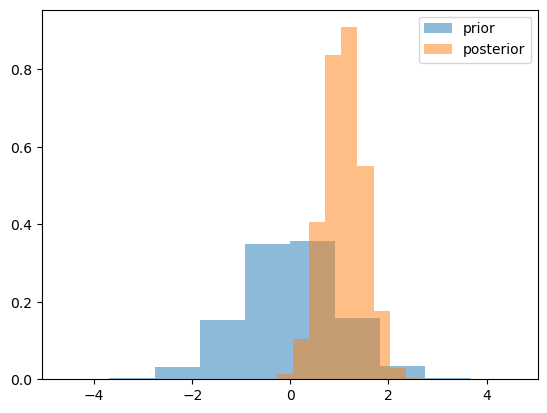

In [165]:
plt.hist(idata.posterior['mu'].values.ravel(), density=True, alpha=0.5, label='prior')
plt.hist(idata.posterior['mu_'].values.ravel(), density=True, alpha=0.5, label='posterior')
plt.legend();

# Gaussian Process Regression (2 minutes)
Suppose $y_i = f(x_i) + \epsilon_i$ for  $\epsilon_i\sim \mathcal N (0,\sigma^2)$ and smooth function $f$

***Gaussian Process Regression*** uses a ***Gaussian Process (GP)*** model for the smooth function $f$  

<font style='color:white'>$$f(\mathbf x) \sim GP(\mu,K) = \mathcal N(\boldsymbol \mu = \mu(\mathbf{x}), \mathbf K = K(\mathbf{x},\mathbf{x})) \quad \text{ so } \quad \mathbf{y} \sim \mathcal N (f(\mathbf{x}), I\sigma^2)$$</font>

<font style='color:white'>$$\text{with}\quad  \boldsymbol \mu = \underbrace{[\mu(x_1), ...,\mu(x_n)]}_{\text{The "regression"}} \quad \text{and} \quad \scriptsize
\mathbf{K} = 
\underbrace{\begin{bmatrix}
k(x_1,x_1) & \dots & k(x_1,x_n)\\
\vdots & \ddots & \vdots\\
k(x_n, x_1) & \dots & k(x_n, x_n)\\
\end{bmatrix}}_{\text{The "covariance kernel matrix"}}
$$</font>

<font style='color:white'>***Random variables*** whose dependency structure and instantiation occur over an indexable domain (time, space, etc.) are called ***stochastic processes***; so, a ***GP*** is a ***multivariate Gaussian random variable (MVN)*** which is a ***stochastic process*** realized over indexable domain $\mathcal X$ defining dependency structure through a so-called ***covariance kernel*** $K$</font>

<font style='color:white'>Example ***covariance kernels*** are available [here] with the common ***exponential quadratic kernel*** specification being</font>

<font style='color:white'>$$K(x_1, x_2) =  \alpha^2 \exp\left(-\frac{||x_1 - x_2||^2}{\lambda^2}\right) \text{ for amplitude $\alpha$ and length scale $\lambda$}$$</font>

<font style='color:white'>so the "farther apart" you are on the inexable domain $\mathcal X$ the smaller the ***covariance***</font>




# Gaussian Process Regression (5 minutes)
Suppose $y_i = f(x_i) + \epsilon_i$ for  $\epsilon_i\sim \mathcal N (0,\sigma^2)$ and smooth function $f$

***Gaussian Process Regression*** uses a ***Gaussian Process (GP)*** model for the smooth function $f$  

$$f(\mathbf x) \sim GP(\mu,K) = \mathcal N(\boldsymbol \mu = \mu(\mathbf{x}), \mathbf K = K(\mathbf{x},\mathbf{x})) \quad \text{ so } \quad \mathbf{y} \sim \mathcal N (f(\mathbf{x}), I\sigma^2)$$

$$\text{with}\quad  \boldsymbol \mu = \underbrace{[\mu(x_1), ...,\mu(x_n)]}_{\text{The "regression"}} \quad \text{and} \quad \scriptsize
\mathbf{K} = 
\underbrace{\begin{bmatrix}
k(x_1,x_1) & \dots & k(x_1,x_n)\\
\vdots & \ddots & \vdots\\
k(x_n, x_1) & \dots & k(x_n, x_n)\\
\end{bmatrix}}_{\text{The "covariance kernel matrix"}}
$$

<font style='color:white'>***Random variables*** whose dependency structure and instantiation occur over an indexable domain (time, space, etc.) are called ***stochastic processes***; so, a ***GP*** is a ***multivariate Gaussian random variable (MVN)*** which is a ***stochastic process*** realized over indexable domain $\mathcal X$ defining dependency structure through a so-called ***covariance kernel*** $K$</font>

<font style='color:white'>Example ***covariance kernels*** are available [here] with the common ***exponential quadratic kernel*** specification being</font>

<font style='color:white'>$$K(x_1, x_2) =  \alpha^2 \exp\left(-\frac{||x_1 - x_2||^2}{\lambda^2}\right) \text{ for amplitude $\alpha$ and length scale $\lambda$}$$</font>

<font style='color:white'>so the "farther apart" you are on the inexable domain $\mathcal X$ the smaller the ***covariance***</font>




# Gaussian Process Regression (3 minutes)
Suppose $y_i = f(x_i) + \epsilon_i$ for  $\epsilon_i\sim \mathcal N (0,\sigma^2)$ and smooth function $f$

***Gaussian Process Regression*** uses a ***Gaussian Process (GP)*** model for the smooth function $f$  

$$f(\mathbf x) \sim GP(\mu,K) = \mathcal N(\boldsymbol \mu = \mu(\mathbf{x}), \mathbf K = K(\mathbf{x},\mathbf{x})) \quad \text{ so } \quad \mathbf{y} \sim \mathcal N (f(\mathbf{x}), I\sigma^2)$$

$$\text{with}\quad  \boldsymbol \mu = \underbrace{[\mu(x_1), ...,\mu(x_n)]}_{\text{The "regression"}} \quad \text{and} \quad \scriptsize
\mathbf{K} = 
\underbrace{\begin{bmatrix}
k(x_1,x_1) & \dots & k(x_1,x_n)\\
\vdots & \ddots & \vdots\\
k(x_n, x_1) & \dots & k(x_n, x_n)\\
\end{bmatrix}}_{\text{The "covariance kernel matrix"}}
$$

***Random variables*** whose dependency structure and instantiation occur over an indexable domain (time, space, etc.) are called ***stochastic processes***; so, a ***GP*** is a ***multivariate Gaussian random variable (MVN)*** which is a ***stochastic process*** realized over indexable domain $\mathcal X$ defining dependency structure through a so-called ***covariance kernel*** $K$

<font style='color:white'>Example ***covariance kernels*** are available [here] with the common ***exponential quadratic kernel*** specification being</font>

<font style='color:white'>$$K(x_1, x_2) =  \alpha^2 \exp\left(-\frac{||x_1 - x_2||^2}{\lambda^2}\right) \text{ for amplitude $\alpha$ and length scale $\lambda$}$$</font>

<font style='color:white'>so the "farther apart" you are on the inexable domain $\mathcal X$ the smaller the ***covariance***</font>




# Gaussian Process Regression (5 minutes)
Suppose $y_i = f(x_i) + \epsilon_i$ for  $\epsilon_i\sim \mathcal N (0,\sigma^2)$ and smooth function $f$

***Gaussian Process Regression*** uses a ***Gaussian Process (GP)*** model for the smooth function $f$  

$$f(\mathbf x) \sim GP(\mu,K) = \mathcal N(\boldsymbol \mu = \mu(\mathbf{x}), \mathbf K = K(\mathbf{x},\mathbf{x})) \quad \text{ so } \quad \mathbf{y} \sim \mathcal N (f(\mathbf{x}), I\sigma^2)$$

$$\text{with}\quad  \boldsymbol \mu = \underbrace{[\mu(x_1), ...,\mu(x_n)]}_{\text{The "regression"}} \quad \text{and} \quad \scriptsize
\mathbf{K} = 
\underbrace{\begin{bmatrix}
k(x_1,x_1) & \dots & k(x_1,x_n)\\
\vdots & \ddots & \vdots\\
k(x_n, x_1) & \dots & k(x_n, x_n)\\
\end{bmatrix}}_{\text{The "covariance kernel matrix"}}
$$

***Random variables*** whose dependency structure and instantiation occur over an indexable domain (time, space, etc.) are called ***stochastic processes***; so, a ***GP*** is a ***multivariate Gaussian random variable (MVN)*** which is a ***stochastic process*** realized over indexable domain $\mathcal X$ defining dependency structure through a so-called ***covariance kernel*** $K$

Example ***covariance kernels*** are available [here](https://peterroelants.github.io/posts/gaussian-process-kernels/) with the common ***exponential quadratic kernel*** specification being

$$K(x_1, x_2) =  \alpha^2 \exp\left(-\frac{||x_1 - x_2||^2}{\lambda^2}\right) \text{ for amplitude $\alpha$ and length scale $\lambda$}$$

<font style='color:navy'>so the "farther apart" you are on the inexable domain $\mathcal X$ the smaller the ***covariance***</font>




# What we see of GPs are MVNs (multivariate normal distributions)<br>(6 minutes)

A ***GP*** is a the collection of ***random variables*** $\{y_x|x\in \mathcal X\}$ defined over indexable domain $\mathcal X$ for which any arbitrary finite subset $\{x_1, x_2, ..., x_n\} \subset \mathcal X$, $\{y_{x_1}, y_{x_2},... y_{x_n}\}$ follow a ***MVN*** (further  detailed in this [video](https://www.youtube.com/watch?v=4vGiHC35j9s)
and [textbook](http://www.gaussianprocess.org/gpml/))
- <font style='color:white'>***GP***s are ***infinite random variables*** for infinte $\mathcal X$, slightly generalizing ***MVN***s which are ***finite random variables***</font>
- <font style='color:white'>All that's needed to define a ***GP*** (assuming a mean $0$ specification) is a ***covaraince kernel*** defining a symetric and positive-definite covariance matrix for $\{y_{x_1}, y_{x_2},..., y_{x_n}\}$ as a function of $\{x_1, x_2, ..., x_n\} \subset x$</font>

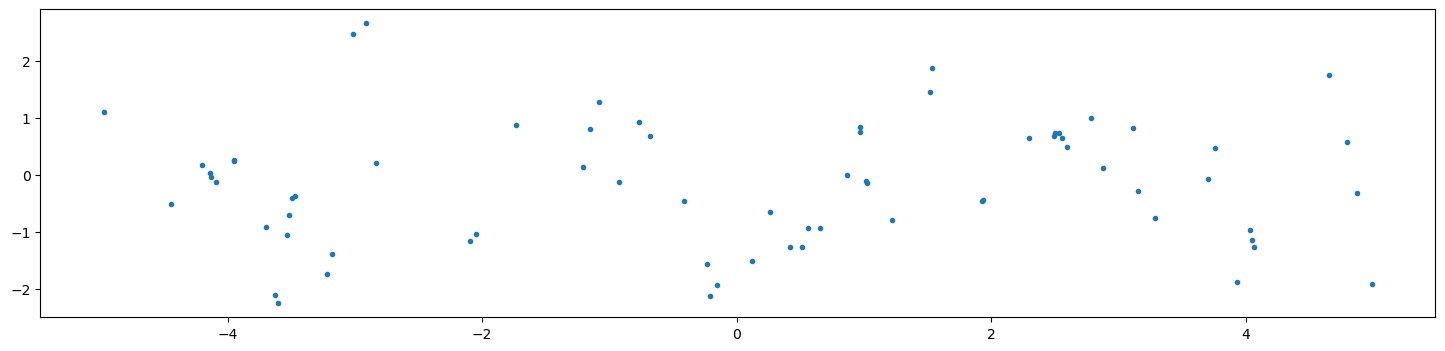

In [18]:
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt
np.random.seed(366); sigma2,_lambda=1,.1; n = 70
x = np.sort(stats.uniform(-5,10).rvs(size=n))[:,np.newaxis]; K = sigma2*np.exp(-(x - x.T)**2/_lambda**2); K=(K+K.T)/2
plt.figure(figsize=(18,4)); plt.plot(x,stats.multivariate_normal(cov=K,allow_singular=True).rvs(1),'.');

# What we see of GPs are MVNs (multivariate normal distributions)<br>(2 minutes)

A ***GP*** is a the collection of ***random variables*** $\{y_x|x\in \mathcal X\}$ defined over indexable domain $\mathcal X$ for which any arbitrary finite subset $\{x_1, x_2, ..., x_n\} \subset \mathcal X$, $\{y_{x_1}, y_{x_2},... y_{x_n}\}$ follow a ***MVN*** (further  detailed in this [video](https://www.youtube.com/watch?v=4vGiHC35j9s)
and [textbook](http://www.gaussianprocess.org/gpml/))
- ***GP***s are ***infinite random variables*** for infinte $\mathcal X$, slightly generalizing ***MVN***s which are ***finite random variables***
- <font style='color:white'>All that's needed to define a ***GP*** (assuming a mean $0$ specification) is a ***covaraince kernel*** defining a symetric and positive-definite covariance matrix for $\{y_{x_1}, y_{x_2},..., y_{x_n}\}$ as a function of $\{x_1, x_2, ..., x_n\} \subset x$</font>

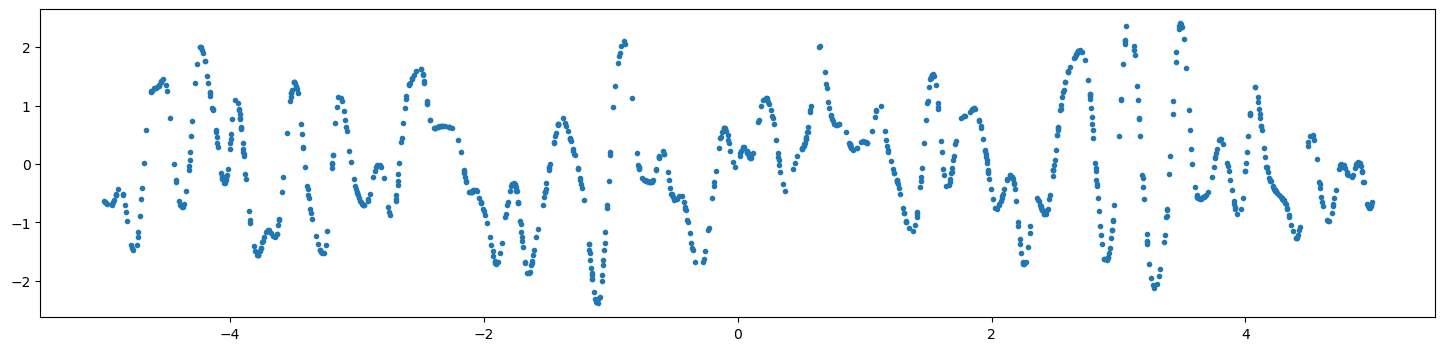

In [16]:
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt
np.random.seed(365); sigma2,_lambda=1,.1; n = 1000
x = np.sort(stats.uniform(-5,10).rvs(size=n))[:,np.newaxis]; K = sigma2*np.exp(-(x - x.T)**2/_lambda**2); K=(K+K.T)/2
plt.figure(figsize=(18,4)); plt.plot(x,stats.multivariate_normal(cov=K,allow_singular=True).rvs(1),'.');

# What we see of GPs are MVNs (multivariate normal distributions)<br>(7 minutes)

A ***GP*** is a the collection of ***random variables*** $\{y_x|x\in \mathcal X\}$ defined over indexable domain $\mathcal X$ for which any arbitrary finite subset $\{x_1, x_2, ..., x_n\} \subset \mathcal X$, $\{y_{x_1}, y_{x_2},... y_{x_n}\}$ follow a ***MVN*** (further  detailed in this [video](https://www.youtube.com/watch?v=4vGiHC35j9s)
and [textbook](http://www.gaussianprocess.org/gpml/))
- ***GP***s are ***infinite random variables*** for infinte $\mathcal X$, slightly generalizing ***MVN***s which are ***finite random variables***
- All that's needed to define a ***GP*** (assuming a mean $0$ specification) is a ***covaraince kernel*** defining a symetric and positive-definite covariance matrix for $\{y_{x_1}, y_{x_2},..., y_{x_n}\}$ as a function of $\{x_1, x_2, ..., x_n\} \subset x$

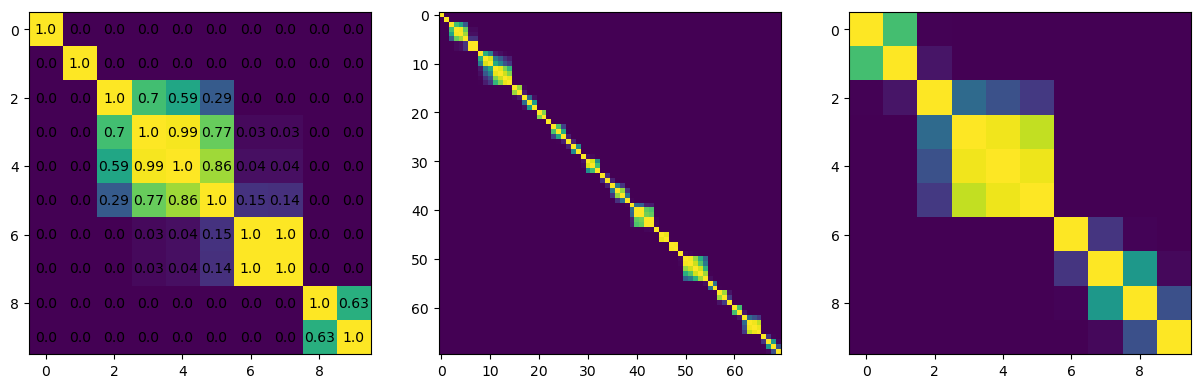

In [19]:
K = sigma2*np.exp(-(x - x.T)**2/_lambda**2); K=(K+K.T)/2; fig,ax = plt.subplots(1,3, figsize=(15,15)); ax[1].imshow(K)
ax[0].imshow(K[:10,:10]); ax[2].imshow(K[-10:,-10:]); xi,xj = np.meshgrid(np.arange(10,dtype=int),np.arange(10,dtype=int)); 
for i,j,s in zip(xi.flatten(),xj.flatten(), K[:10,:10].round(2).flatten()):
    ax[0].text(x=i,y=j,s=s, verticalalignment='center', horizontalalignment='center')

# Bayesian GPs (2 minutes)


***GP***s readily admit a hierarchical Bayesian (generative modeling) specification.

\begin{align}
f(\mathbf x) \sim {} & GP(\mu,K) = \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x}))\\
{}& \quad\quad\quad\quad\quad\quad\quad\quad \color{white}{\theta \sim  p(\theta) \quad\; \tau \sim p(\tau)} \\
\color{white}{\mathbf{x} \sim} {} &\color{white}{ p(X) \propto 1 \quad \text{or just taken as given and "fixed" as usual}}\\
\color{white}{\mathbf{y} \sim} {} & \color{white}{\mathcal N (E[\mathbf{y}]= f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \quad \text{ with } \quad \sigma^2 \sim p(\sigma^2)}\\
{}& \color{white}{\text{for an independent homoskedastic variance prior}}\\\\
\color{white}{\text{so} \quad p(f(\mathbf x)|-) \propto} {} &  \color{white}{\mathcal N (E[\mathbf{y}] = f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x})) p(\theta, \tau, \sigma^2, \mathbf{x})}\\
{}& \color{white}{\text{which even has closed analytical posterior for }\textbf{MVN conjugate priors}}
\end{align}

<font style='color:white'>PyMC has [many] ***GP*** tutorials, e.g., on [covariance functions] and [latent] (versus marginalized) ***GP*** implementations</font>


# Bayesian GPs (1 minute)


***GP***s readily admit a hierarchical Bayesian (generative modeling) specification.

\begin{align}
f(\mathbf x) \sim {} & GP(\mu,K) = \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x}))\\
{}& \quad\quad\quad\quad\quad\quad\quad\quad \theta \sim  p(\theta) \quad\; \tau \sim p(\tau) \\
\mathbf{x} \sim {} & p(X) \propto 1 \quad \text{or just taken as given and "fixed" as usual}\\
\color{white}{\mathbf{y} \sim} {} & \color{white}{\mathcal N (E[\mathbf{y}]= f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \quad \text{ with } \quad \sigma^2 \sim p(\sigma^2)}\\
{}& \color{white}{\text{for an independent homoskedastic variance prior}}\\\\
\color{white}{\text{so} \quad p(f(\mathbf x)|-) \propto} {} &  \color{white}{\mathcal N (E[\mathbf{y}] = f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x})) p(\theta, \tau, \sigma^2, \mathbf{x})}\\
{}& \color{white}{\text{which even has closed analytical posterior for }\textbf{MVN conjugate priors}}
\end{align}

<font style='color:white'>PyMC has [many] ***GP*** tutorials, e.g., on [covariance functions] and [latent] (versus marginalized) ***GP*** implementations</font>


# Bayesian GPs (1 minute)


***GP***s readily admit a hierarchical Bayesian (generative modeling) specification.

\begin{align}
f(\mathbf x) \sim {} & GP(\mu,K) = \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x}))\\
{}& \quad\quad\quad\quad\quad\quad\quad\quad \theta \sim  p(\theta) \quad\; \tau \sim p(\tau) \\
\mathbf{x} \sim {} & p(X) \propto 1 \quad \text{or just taken as given and "fixed" as usual}\\
\mathbf{y} \sim {} & \mathcal N (E[\mathbf{y}]= f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \color{white}{\quad \text{ with } \quad \sigma^2 \sim p(\sigma^2)}\\
{}& \color{white}{\text{for an independent homoskedastic variance prior}}\\\\
\color{white}{\text{so} \quad p(f(\mathbf x)|-) \propto} {} &  \color{white}{\mathcal N (E[\mathbf{y}] = f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x})) p(\theta, \tau, \sigma^2, \mathbf{x})}\\
{}& \color{white}{\text{which even has closed analytical posterior for }\textbf{MVN conjugate priors}}
\end{align}

<font style='color:white'>PyMC has [many] ***GP*** tutorials, e.g., on [covariance functions] and [latent] (versus marginalized) ***GP*** implementations</font>


# Bayesian GPs (1 minute)


***GP***s readily admit a hierarchical Bayesian (generative modeling) specification.

\begin{align}
f(\mathbf x) \sim {} & GP(\mu,K) = \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x}))\\
{}& \quad\quad\quad\quad\quad\quad\quad\quad \theta \sim  p(\theta) \quad\; \tau \sim p(\tau) \\
\mathbf{x} \sim {} & p(X) \propto 1 \quad \text{or just taken as given and "fixed" as usual}\\
\mathbf{y} \sim {} & \mathcal N (E[\mathbf{y}]= f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \quad \text{ with } \quad \sigma^2 \sim p(\sigma^2)\\
{}& \text{for an independent homoskedastic variance prior}\\\\
\color{white}{\text{so} \quad p(f(\mathbf x)|-) \propto} {} &  \color{white}{\mathcal N (E[\mathbf{y}] = f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x})) p(\theta, \tau, \sigma^2, \mathbf{x})}\\
{}& \color{white}{\text{which even has closed analytical posterior for }\textbf{MVN conjugate priors}}
\end{align}

<font style='color:white'>PyMC has [many] ***GP*** tutorials, e.g., on [covariance functions] and [latent] (versus marginalized) ***GP*** implementations</font>


# Bayesian GPs (1 minute)


***GP***s readily admit a hierarchical Bayesian (generative modeling) specification.

\begin{align}
f(\mathbf x) \sim {} & GP(\mu,K) = \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x}))\\
{}& \quad\quad\quad\quad\quad\quad\quad\quad \theta \sim  p(\theta) \quad\; \tau \sim p(\tau) \\
\mathbf{x} \sim {} & p(X) \propto 1 \quad \text{or just taken as given and "fixed" as usual}\\
\mathbf{y} \sim {} & \mathcal N (E[\mathbf{y}]= f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \quad \text{ with } \quad \sigma^2 \sim p(\sigma^2)\\
{}& \text{for an independent homoskedastic variance prior}\\\\
\text{so} \quad p(f(\mathbf x)|-) \propto {} &  \color{white}{\mathcal N (E[\mathbf{y}] = f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x})) p(\theta, \tau, \sigma^2, \mathbf{x})}\\
{}& \color{white}{\text{which even has closed analytical posterior for }\textbf{MVN conjugate priors}}
\end{align}

<font style='color:white'>PyMC has [many] ***GP*** tutorials, e.g., on [covariance functions] and [latent] (versus marginalized) ***GP*** implementations</font>


# Bayesian GPs (1 minute)


***GP***s readily admit a hierarchical Bayesian (generative modeling) specification.

\begin{align}
f(\mathbf x) \sim {} & GP(\mu,K) = \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x}))\\
{}& \quad\quad\quad\quad\quad\quad\quad\quad \theta \sim  p(\theta) \quad\; \tau \sim p(\tau) \\
\mathbf{x} \sim {} & p(X) \propto 1 \quad \text{or just taken as given and "fixed" as usual}\\
\mathbf{y} \sim {} & \mathcal N (E[\mathbf{y}]= f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \quad \text{ with } \quad \sigma^2 \sim p(\sigma^2)\\
{}& \text{for an independent homoskedastic variance prior}\\\\
\text{so} \quad p(f(\mathbf x)|-) \propto {} &  \mathcal N (E[\mathbf{y}] = f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \color{white}{\mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x})) p(\theta, \tau, \sigma^2, \mathbf{x})}\\
{}& \color{white}{\text{which even has closed analytical posterior for }\textbf{MVN conjugate priors}}
\end{align}

<font style='color:white'>PyMC has [many] ***GP*** tutorials, e.g., on [covariance functions] and [latent] (versus marginalized) ***GP*** implementations</font>


# Bayesian GPs (1 minute)


***GP***s readily admit a hierarchical Bayesian (generative modeling) specification.

\begin{align}
f(\mathbf x) \sim {} & GP(\mu,K) = \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x}))\\
{}& \quad\quad\quad\quad\quad\quad\quad\quad \theta \sim  p(\theta) \quad\; \tau \sim p(\tau) \\
\mathbf{x} \sim {} & p(X) \propto 1 \quad \text{or just taken as given and "fixed" as usual}\\
\mathbf{y} \sim {} & \mathcal N (E[\mathbf{y}]= f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \quad \text{ with } \quad \sigma^2 \sim p(\sigma^2)\\
{}& \text{for an independent homoskedastic variance prior}\\\\
\text{so} \quad p(f(\mathbf x)|-) \propto {} &  \mathcal N (E[\mathbf{y}] = f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x})) \color{white}{p(\theta, \tau, \sigma^2, \mathbf{x})}\\
{}& \color{white}{\text{which even has closed analytical posterior for }\textbf{MVN conjugate priors}}
\end{align}

<font style='color:white'>PyMC has [many] ***GP*** tutorials, e.g., on [covariance functions] and [latent] (versus marginalized) ***GP*** implementations</font>


# Bayesian GPs (1 minute)


***GP***s readily admit a hierarchical Bayesian (generative modeling) specification.

\begin{align}
f(\mathbf x) \sim {} & GP(\mu,K) = \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x}))\\
{}& \quad\quad\quad\quad\quad\quad\quad\quad \theta \sim  p(\theta) \quad\; \tau \sim p(\tau) \\
\mathbf{x} \sim {} & p(X) \propto 1 \quad \text{or just taken as given and "fixed" as usual}\\
\mathbf{y} \sim {} & \mathcal N (E[\mathbf{y}]= f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \quad \text{ with } \quad \sigma^2 \sim p(\sigma^2)\\
{}& \text{for an independent homoskedastic variance prior}\\\\
\text{so} \quad p(f(\mathbf x)|-) \propto {} &  \mathcal N (E[\mathbf{y}] = f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x})) p(\theta, \tau, \sigma^2, \mathbf{x})\\
{}& \text{which even has closed analytical posterior for }\textbf{MVN conjugate priors}
\end{align}

<font style='color:white'>PyMC has [many] ***GP*** tutorials, e.g., on [covariance functions] and [latent] (versus marginalized) ***GP*** implementations</font>


# Bayesian GPs (1 minute)


***GP***s readily admit a hierarchical Bayesian (generative modeling) specification.

\begin{align}
f(\mathbf x) \sim {} & GP(\mu,K) = \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x}))\\
{}& \quad\quad\quad\quad\quad\quad\quad\quad \theta \sim  p(\theta) \quad\; \tau \sim p(\tau) \\
\mathbf{x} \sim {} & p(X) \propto 1 \quad \text{or just taken as given and "fixed" as usual}\\
\mathbf{y} \sim {} &  \mathcal N (E[\mathbf{y}]= f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \quad \text{ with } \quad \sigma^2 \sim p(\sigma^2)\\
{}& \text{for an independent homoskedastic variance prior}\\\\
\text{so} \quad p(f(\mathbf x)|-) \propto {} &  \mathcal N (E[\mathbf{y}] = f(\mathbf{x}), \text{Var}[\mathbf{y}] = I\sigma^2) \mathcal N(\boldsymbol \mu = \mu_\theta(\mathbf{x}), \mathbf K = K_\tau(\mathbf{x},\mathbf{x})) p(\theta, \tau, \sigma^2, \mathbf{x})\\
{}& \text{which even has closed analytical posterior for }\textbf{MVN conjugate priors}
\end{align}

`PyMC` has [many](https://www.pymc.io/projects/examples/en/latest/gallery.html#gaussian-processes) ***GP*** [tutorials](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/Gaussian_Processes.html), e.g., on [covariance functions](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MeansAndCovs.html) and [latent](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Latent.html) (versus marginalized) ***GP*** implementations


In [21]:
k,b,x_min,x_max,n = 1,5,-50,50,150 # Haining Tan
def aleatoric(x): # variablity function for a particular x
    r = (x - x_min) / (x_max - x_min); return 2 * r

def generate_data(n):
    x = (x_max - x_min) * np.random.rand(n) + x_min 
    noise = np.random.randn(n) * aleatoric(x)
    y = (k * x * (1 + np.sin(x)) + b) + noise; x = x[..., np.newaxis]
    return x, y

# `PyMC` GPs (5 minutes)


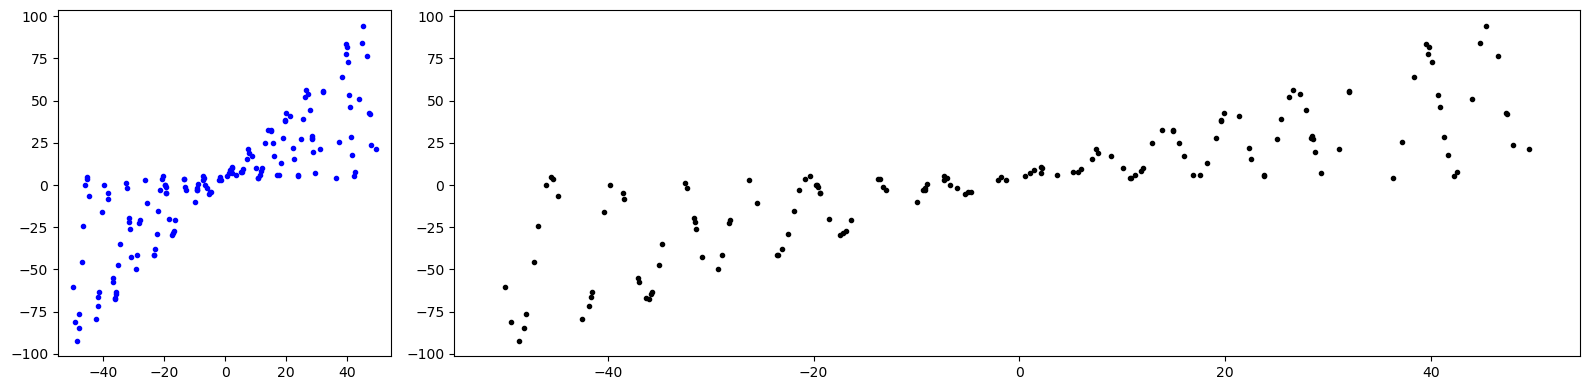

In [22]:
x_train, y_train = generate_data(n); x_test, y_test = generate_data(n); import matplotlib.gridspec as gridspec; fig=plt.figure(tight_layout=True, figsize=(16,4)); gs=gridspec.GridSpec(1, 4);ax=fig.add_subplot(gs[0]);ax.plot(x_train, y_train, "b.");ax=fig.add_subplot(gs[1:]);ax.plot(x_train, y_train, "k.");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ita, iota, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 731 seconds.


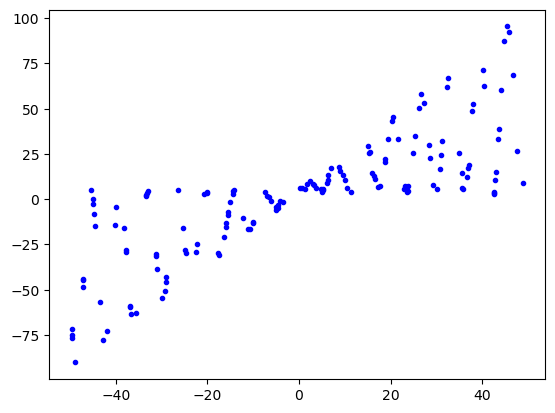

In [131]:
import pymc as pm # adapted from Haining Tan 
with pm.Model() as gp_model:    
    ita = pm.HalfNormal('ita', sigma=5); iota = pm.Gamma('iota', alpha=4, beta=2)
    sq_exp = ita ** 2 * pm.gp.cov.ExpQuad(input_dim=1, ls=iota) # exponential quadratic kernel
    gp = pm.gp.Marginal(cov_func=sq_exp); sigma = pm.HalfNormal('sigma', sigma=5, initval=1)
    y_ = gp.marginal_likelihood('y', X=x_train, y=y_train, sigma=sigma)
with gp_model:
    tr = pm.sample(target_accept=0.95, return_inferencedata=True)      

# `PyMC` GPs (5 minutes)


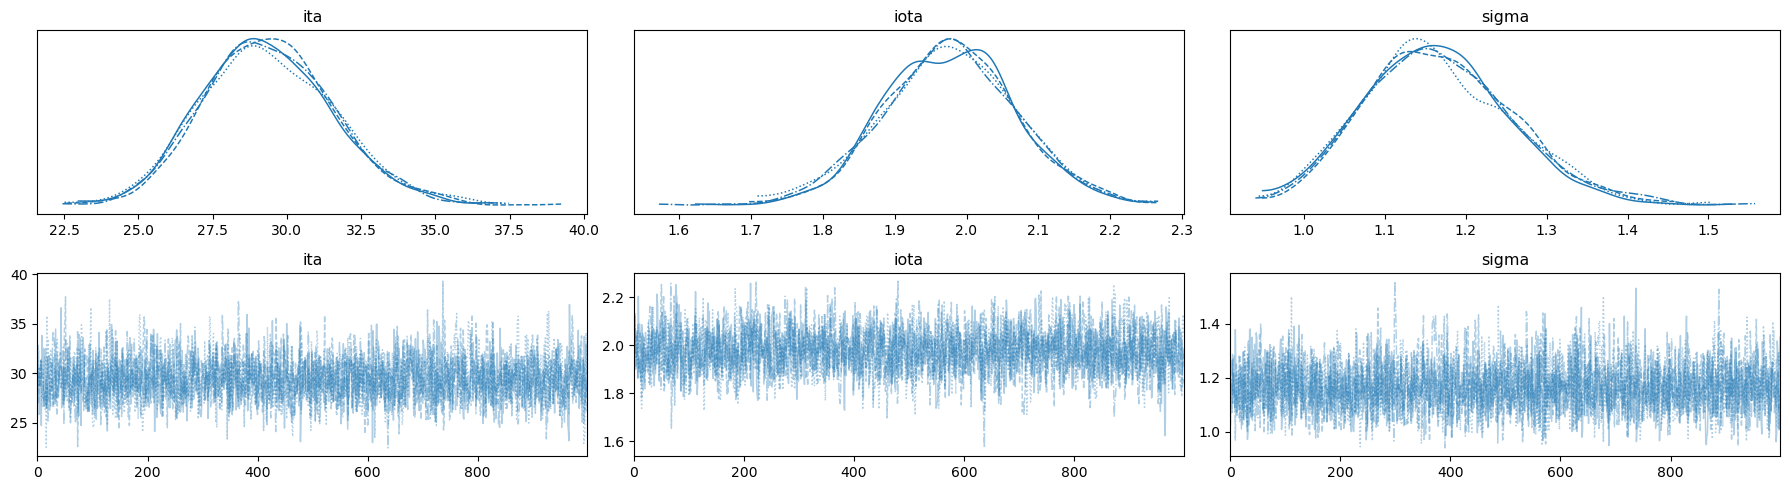

In [159]:
import arviz as az; fig,ax = plt.subplots(2,3,figsize=(18,5)); az.plot_trace(tr, var_names=['ita', 'iota', 'sigma'],axes=ax.T); plt.tight_layout()

In [161]:
Xnew = np.linspace(-75 , 75, 200)
with gp_model:
    predy = gp.conditional("predy", Xnew=Xnew[:, np.newaxis])
    ppred = pm.sample_posterior_predictive(tr, var_names=['predy'])

Sampling: [predy]


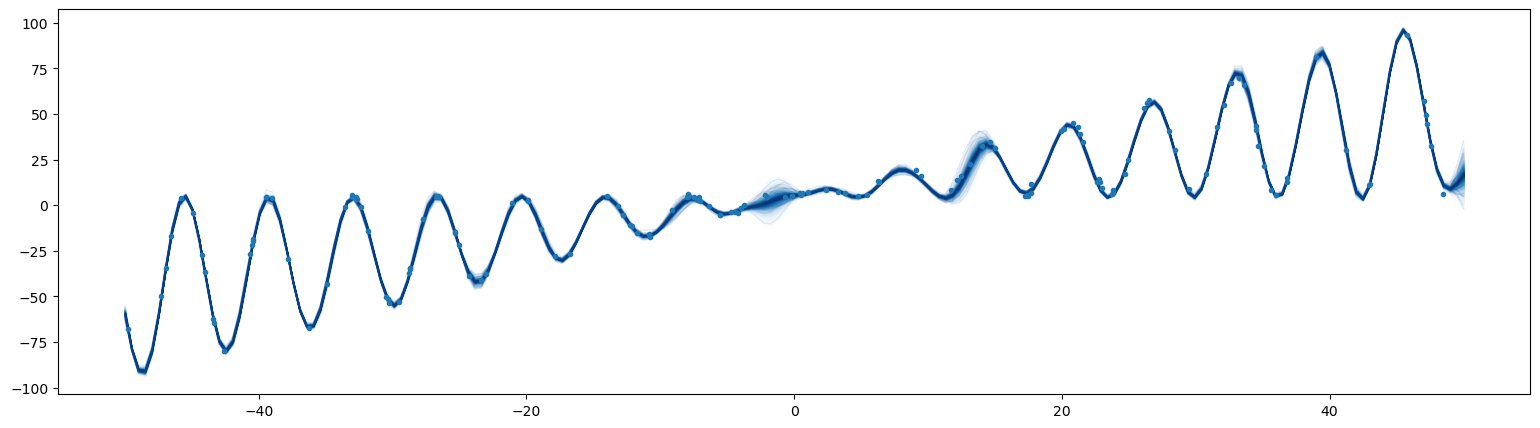

In [154]:
fig = plt.figure(figsize=(18, 5)); ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, ppred.posterior_predictive['pred'].values.reshape(-1,4000,200)[0,:], Xnew, plot_samples=True, palette='Blues'); ax.plot(x, y, '.'); 

# `PyMC` GPs (5 mintues)


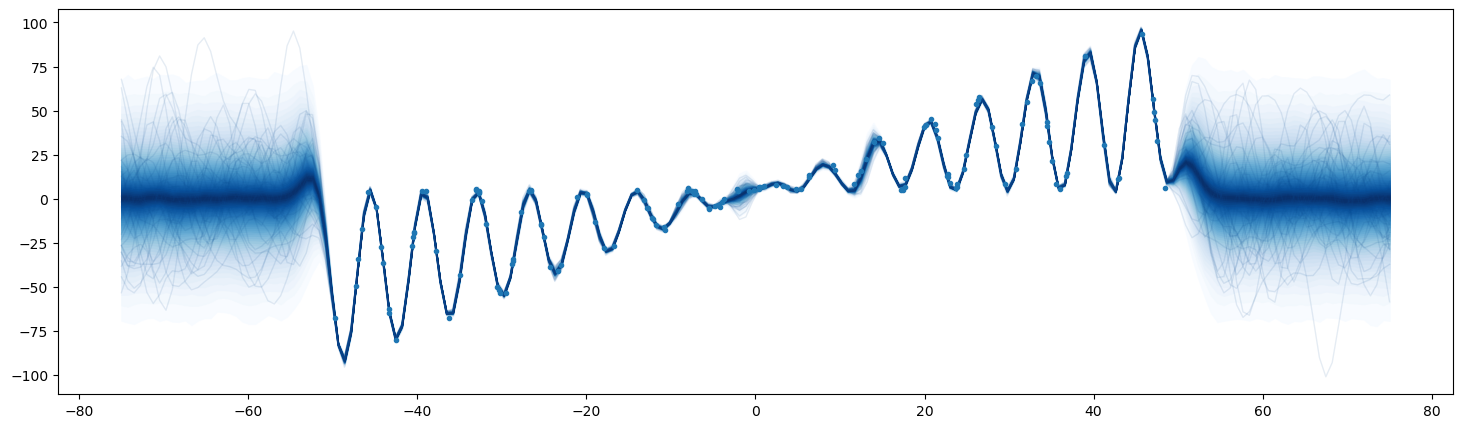

In [162]:
fig = plt.figure(figsize=(18, 5)); ax = plt.gca(); 
pm.gp.util.plot_gp_dist(ax, ppred.posterior_predictive['predy'].values.reshape(-1,4000,200)[0,:], Xnew, plot_samples=True, palette='Blues'); ax.plot(x, y, '.'); 

In [143]:
Xnew = np.linspace(-50 , 50, 200)
with gp_model:
    pred = gp.conditional("pred", Xnew=Xnew[:, np.newaxis])
    ppred = pm.sample_posterior_predictive(tr, var_names=['pred'])

Sampling: [pred]


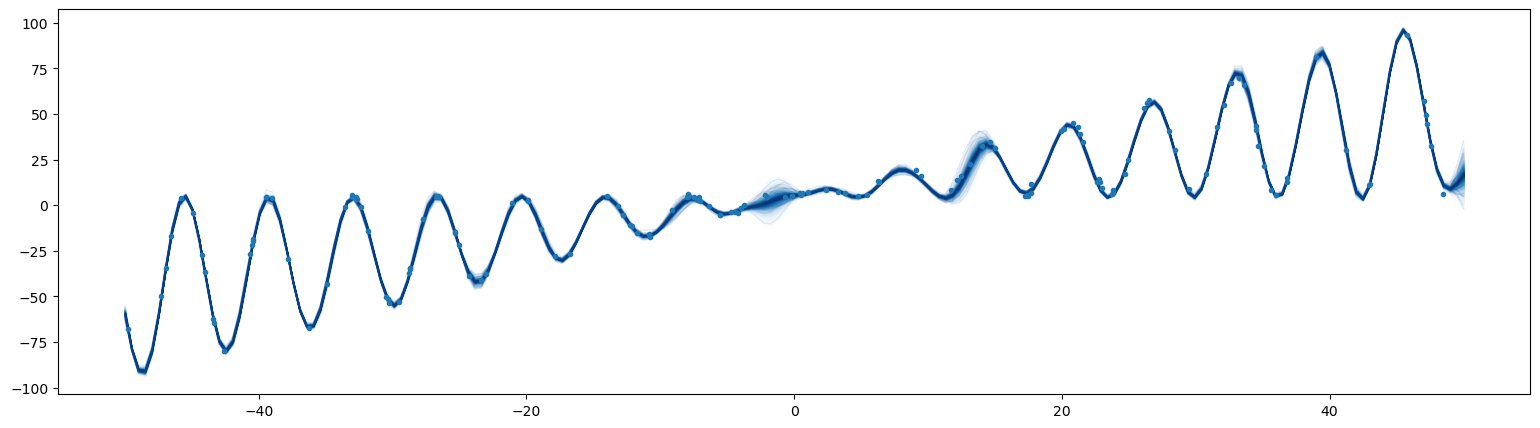

In [154]:
fig = plt.figure(figsize=(18, 5)); ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, ppred.posterior_predictive['pred'].values.reshape(-1,4000,200)[0,:], Xnew, plot_samples=True, palette='Blues'); ax.plot(x, y, '.'); 

# Conditional MVN distributions (are MVN distributions) (2 minutes)

Given $\mathbf x$ and observed $\mathbf y$ the ***GP posterior*** $p(f(\mathbf x^*)|-)$ characterizing uncertainty over smooth functions passing closely through $(\mathbf x,\mathbf y)$ according to the noise inference $p(\sigma^2|-)$ is a [***conditional MVN distribution***](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions)

<font style="color:white">This follows since $f( \mathbf{\tilde x} = (\mathbf x,\mathbf x^*) )$ (given all model parameters) is ***MVN***</font>

<font style="color:white">$$p\left(\mathbf{\tilde x}\;\Bigg|\;\boldsymbol \mu = \left[\begin{array}{c} \underset{n\times1}{\boldsymbol \mu_{\mathbf{ x}}}\\ \underset{m\times1}{\boldsymbol \mu_{\mathbf{ x^*}}} \end{array} \right], \boldsymbol \Sigma = \left[\begin{array}{cc}  \underset{n\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x}}} &  \underset{n\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x},\mathbf{x^*}}}\\  \underset{m \times n}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}} =  {\boldsymbol {\Sigma }}_{\mathbf{x},\mathbf{x^*}}^T} &  \underset{m\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x*}}}\end{array}\right] \right) = {\frac {\exp \left(-{\frac {1}{2}}\left({\mathbf {\tilde x} }-{\boldsymbol {\mu }}\right)^{\mathrm {T} }{\boldsymbol {\Sigma }}^{-1}\left({\mathbf {\tilde x} }-{\boldsymbol {\mu }}\right)\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma }}|}}}$$</font>

<font style="color:white">and the ***conditional distribution*** $f(\mathbf x^* | \mathbf x)$ of a ***MVN*** is also ***MVN***</font>
 
<font style="color:white">$$\mathbf{x^*} | \mathbf x, \boldsymbol \mu, \boldsymbol \Sigma \sim  \mathcal{MVN}\left( {\bar {\boldsymbol {\mu }}}= \underset{m\times1}{{\boldsymbol {\mu }}_{\mathbf{x^*}}}+ \underset{m\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}}}  \underset{n\times n}{{\boldsymbol {\Sigma}}^{-1}_{\mathbf{x}}} \underset{n\times1}{\left(\mathbf {x} -{\boldsymbol {\mu }}_{\mathbf{x}}\right)},  {\overline {\boldsymbol {\Sigma }}}= \underset{m\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}}}- \underset{m\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}}}  \underset{n\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x}}^{-1}} \underset{n\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x},\mathbf{x^*}}}  \right)$$</font>

<font style="color:white">But if ${\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}} \approx \mathbf{0}_{m \times n}$ then $\mathbf{x^*}$ is essentially independent of $\mathbf{x}$ so there is no information in the updated prediction and so ***GP*** samples are just informed by the ***prior*** specification of the ***GP***</font>


# Conditional MVN distributions (are MVN distributions) (4 minutes)

Given $\mathbf x$ and observed $\mathbf y$ the ***GP posterior*** $p(f(\mathbf x^*)|-)$ characterizing uncertainty over smooth functions passing closely through $(\mathbf x,\mathbf y)$ according to the noise inference $p(\sigma^2|-)$ is a [***conditional MVN distribution***](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions)

This follows since $f( \mathbf{\tilde x} = (\mathbf x,\mathbf x^*) )$ (given all model parameters) is ***MVN***

$$p\left(\mathbf{\tilde x}\;\Bigg|\;\boldsymbol \mu = \left[\begin{array}{c} \underset{n\times1}{\boldsymbol \mu_{\mathbf{ x}}}\\ \underset{m\times1}{\boldsymbol \mu_{\mathbf{ x^*}}} \end{array} \right], \boldsymbol \Sigma = \left[\begin{array}{cc}  \underset{n\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x}}} &  \underset{n\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x},\mathbf{x^*}}}\\  \underset{m \times n}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}} =  {\boldsymbol {\Sigma }}_{\mathbf{x},\mathbf{x^*}}^T} &  \underset{m\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x*}}}\end{array}\right] \right) = {\frac {\exp \left(-{\frac {1}{2}}\left({\mathbf {\tilde x} }-{\boldsymbol {\mu }}\right)^{\mathrm {T} }{\boldsymbol {\Sigma }}^{-1}\left({\mathbf {\tilde x} }-{\boldsymbol {\mu }}\right)\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma }}|}}}$$

<font style="color:white">and the ***conditional distribution*** $f(\mathbf x^* | \mathbf x)$ of a ***MVN*** is also ***MVN***</font>
 
<font style="color:white">$$\mathbf{x^*} | \mathbf x, \boldsymbol \mu, \boldsymbol \Sigma \sim  \mathcal{MVN}\left( {\bar {\boldsymbol {\mu }}}= \underset{m\times1}{{\boldsymbol {\mu }}_{\mathbf{x^*}}}+ \underset{m\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}}}  \underset{n\times n}{{\boldsymbol {\Sigma}}^{-1}_{\mathbf{x}}} \underset{n\times1}{\left(\mathbf {x} -{\boldsymbol {\mu }}_{\mathbf{x}}\right)},  {\overline {\boldsymbol {\Sigma }}}= \underset{m\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}}}- \underset{m\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}}}  \underset{n\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x}}^{-1}} \underset{n\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x},\mathbf{x^*}}}  \right)$$</font>

<font style="color:white">But if ${\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}} \approx \mathbf{0}_{m \times n}$ then $\mathbf{x^*}$ is essentially independent of $\mathbf{x}$ so there is no information in the updated prediction and so ***GP*** samples are just informed by the ***prior*** specification of the ***GP***</font>


# Conditional MVN distributions (are MVN distributions) (6 minutes)

Given $\mathbf x$ and observed $\mathbf y$ the ***GP posterior*** $p(f(\mathbf x^*)|-)$ characterizing uncertainty over smooth functions passing closely through $(\mathbf x,\mathbf y)$ according to the noise inference $p(\sigma^2|-)$ is a [***conditional MVN distribution***](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions)

This follows since $f( \mathbf{\tilde x} = (\mathbf x,\mathbf x^*) )$ (given all model parameters) is ***MVN***

$$p\left(\mathbf{\tilde x}\;\Bigg|\;\boldsymbol \mu = \left[\begin{array}{c} \underset{n\times1}{\boldsymbol \mu_{\mathbf{ x}}}\\ \underset{m\times1}{\boldsymbol \mu_{\mathbf{ x^*}}} \end{array} \right], \boldsymbol \Sigma = \left[\begin{array}{cc}  \underset{n\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x}}} &  \underset{n\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x},\mathbf{x^*}}}\\  \underset{m \times n}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}} =  {\boldsymbol {\Sigma }}_{\mathbf{x},\mathbf{x^*}}^T} &  \underset{m\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x*}}}\end{array}\right] \right) = {\frac {\exp \left(-{\frac {1}{2}}\left({\mathbf {\tilde x} }-{\boldsymbol {\mu }}\right)^{\mathrm {T} }{\boldsymbol {\Sigma }}^{-1}\left({\mathbf {\tilde x} }-{\boldsymbol {\mu }}\right)\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma }}|}}}$$

and the ***conditional distribution*** $f(\mathbf x^* | \mathbf x)$ of a ***MVN*** is also ***MVN***
 
$$\mathbf{x^*} | \mathbf x, \boldsymbol \mu, \boldsymbol \Sigma \sim  \mathcal{MVN}\left( {\bar {\boldsymbol {\mu }}}= \underset{m\times1}{{\boldsymbol {\mu }}_{\mathbf{x^*}}}+ \underset{m\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}}}  \underset{n\times n}{{\boldsymbol {\Sigma}}^{-1}_{\mathbf{x}}} \underset{n\times1}{\left(\mathbf {x} -{\boldsymbol {\mu }}_{\mathbf{x}}\right)},  {\overline {\boldsymbol {\Sigma }}}= \underset{m\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}}}- \underset{m\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}}}  \underset{n\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x}}^{-1}} \underset{n\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x},\mathbf{x^*}}}  \right)$$

<font style="color:white">But if ${\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}} \approx \mathbf{0}_{m \times n}$ then $\mathbf{x^*}$ is essentially independent of $\mathbf{x}$ so there is no information in the updated prediction and so ***GP*** samples are just informed by the ***prior*** specification of the ***GP***</font>


# Conditional MVN distributions (are MVN distributions) (2 minutes)

Given $\mathbf x$ and observed $\mathbf y$ the ***GP posterior*** $p(f(\mathbf x^*)|-)$ characterizing uncertainty over smooth functions passing closely through $(\mathbf x,\mathbf y)$ according to the noise inference $p(\sigma^2|-)$ is a [***conditional MVN distribution***](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions)

This follows since $f( \mathbf{\tilde x} = (\mathbf x,\mathbf x^*) )$ (given all model parameters) is ***MVN*** 

$$p\left(\mathbf{\tilde x}\;\Bigg|\;\boldsymbol \mu = \left[\begin{array}{c} \underset{n\times1}{\boldsymbol \mu_{\mathbf{ x}}}\\ \underset{m\times1}{\boldsymbol \mu_{\mathbf{ x^*}}} \end{array} \right], \boldsymbol \Sigma = \left[\begin{array}{cc}  \underset{n\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x}}} &  \underset{n\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x},\mathbf{x^*}}}\\  \underset{m \times n}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}} =  {\boldsymbol {\Sigma }}_{\mathbf{x},\mathbf{x^*}}^T} &  \underset{m\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x*}}}\end{array}\right] \right) = {\frac {\exp \left(-{\frac {1}{2}}\left({\mathbf {\tilde x} }-{\boldsymbol {\mu }}\right)^{\mathrm {T} }{\boldsymbol {\Sigma }}^{-1}\left({\mathbf {\tilde x} }-{\boldsymbol {\mu }}\right)\right)}{\sqrt {(2\pi )^{k}|{\boldsymbol {\Sigma }}|}}}$$

and the ***conditional distribution*** $f(\mathbf x^* | \mathbf x)$ of a ***MVN*** is also ***MVN***
 
$$\mathbf{x^*} | \mathbf x, \boldsymbol \mu, \boldsymbol \Sigma \sim  \mathcal{MVN}\left( {\bar {\boldsymbol {\mu }}}= \underset{m\times1}{{\boldsymbol {\mu }}_{\mathbf{x^*}}}+ \underset{m\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}}}  \underset{n\times n}{{\boldsymbol {\Sigma}}^{-1}_{\mathbf{x}}} \underset{n\times1}{\left(\mathbf {x} -{\boldsymbol {\mu }}_{\mathbf{x}}\right)},  {\overline {\boldsymbol {\Sigma }}}= \underset{m\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}}}- \underset{m\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}}}  \underset{n\times n}{{\boldsymbol {\Sigma }}_{\mathbf{x}}^{-1}} \underset{n\times m}{{\boldsymbol {\Sigma }}_{\mathbf{x},\mathbf{x^*}}}  \right)$$

But if ${\boldsymbol {\Sigma }}_{\mathbf{x^*}\!\!,\,\mathbf{x}} \approx \mathbf{0}_{m \times n}$ then $\mathbf{x^*}$ is essentially independent of $\mathbf{x}$ so there is no information in the updated prediction and so ***GP*** samples are just informed by the ***prior*** specification of the ***GP***


# Variational Inference: Approximate Bayesian Inference (2 minutes)

## Make Bayesian inference an optimization problem (like MLE inference) <br>rather than a sampling problem (via MCMC)


<font style="color:white">***KL divergence*** provides an ***objective function*** for providing an ***approximate Bayesian inference*** through ***optimization***</font>

<font style="color:white">$$ \min_q KL[\, q(\theta) \, || \, p(\theta|y) \,] \equiv \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,]$$</font>


<font style="color:white"># Kullback-Leibler (KL) divergence</font>

<font style="color:white">***Kullback-Leibler (KL) divergence*** measures a "distance between distributions"</font>

<font style="color:white">$$\overset{\text{remember as notating}}{\underset{\text{$p(\theta)$ is "on the bottom"}}{KL[\, q(\theta) \, || \, p(\theta) \,]  }} = \int \frac{q(\theta)}{p(\theta)} q(\theta) d \theta \quad \text{which is nonnegative}$$</font>

> <font style="color:white">***KL divergence*** <u>does not satisfy</u> the ***triangle equality*** so is not a ***metric***</font>
> <font style="color:white">$KL[\, q(\theta) \, || \, p(\theta) \,] \not \leq KL[\, q(\theta) \, || \, r(\theta) \,] + KL[\, r(\theta) \, || \, p(\theta) \,]$<font><!--; rather,  as seen below $\scriptsize  KL[\, q(\theta) \, || \,  p(\theta) \, ] = KL[\, q(\theta) \, || \,  p(\theta|y) \, ] + E_{q(\theta)}[ \log p(y|\theta)/p(y) ]$ -->



# Variational Inference: Approximate Bayesian Inference (2 minutes)

## Make Bayesian inference an optimization problem (like MLE inference) <br>rather than a sampling problem (via MCMC)


***KL divergence*** provides an ***objective function*** for providing an ***approximate Bayesian inference*** through ***optimization***

$$ \min_q KL[\, q(\theta) \, || \, p(\theta|y) \,] \equiv \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,]$$


# Kullback-Leibler (KL) divergence

<font style="color:white">> ***Kullback-Leibler (KL) divergence*** measures a "distance between distributions"</font>

<font style="color:white">$$\overset{\text{remember as notating}}{\underset{\text{$p(\theta)$ is "on the bottom"}}{KL[\, q(\theta) \, || \, p(\theta) \,]  }} = \int \frac{q(\theta)}{p(\theta)} q(\theta) d \theta \quad \text{which is nonnegative}$$</font>

> <font style="color:white">***KL divergence*** <u>does not satisfy</u> the ***triangle equality*** so is not a ***metric***</font>
> <font style="color:white">$KL[\, q(\theta) \, || \, p(\theta) \,] \not \leq KL[\, q(\theta) \, || \, r(\theta) \,] + KL[\, r(\theta) \, || \, p(\theta) \,]$<font><!--; rather,  as seen below $\scriptsize  KL[\, q(\theta) \, || \,  p(\theta) \, ] = KL[\, q(\theta) \, || \,  p(\theta|y) \, ] + E_{q(\theta)}[ \log p(y|\theta)/p(y) ]$ -->



# Variational Inference: Approximate Bayesian Inference (4 minutes)

## Make Bayesian inference an optimization problem (like MLE inference) <br>rather than a sampling problem (via MCMC)


***KL divergence*** provides an ***objective function*** for providing an ***approximate Bayesian inference*** through ***optimization***

$$ \min_q KL[\, q(\theta) \, || \, p(\theta|y) \,] \equiv \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,]$$


# Kullback-Leibler (KL) divergence

>***Kullback-Leibler (KL) divergence*** measures a "distance between distributions"

$$\overset{\text{remember as notating}}{\underset{\text{$p(\theta)$ is "on the bottom"}}{KL[\, q(\theta) \, || \, p(\theta) \,]  }} = \int \log \left(\frac{q(\theta)}{p(\theta)}\right) q(\theta) d \theta \quad \text{which is nonnegative}$$

> <font style="color:white">***KL divergence*** <u>does not satisfy</u> the ***triangle equality*** so is not a ***metric***</font>
> <font style="color:white">$KL[\, q(\theta) \, || \, p(\theta) \,] \not \leq KL[\, q(\theta) \, || \, r(\theta) \,] + KL[\, r(\theta) \, || \, p(\theta) \,]$<font><!--; rather,  as seen below $\scriptsize  KL[\, q(\theta) \, || \,  p(\theta) \, ] = KL[\, q(\theta) \, || \,  p(\theta|y) \, ] + E_{q(\theta)}[ \log p(y|\theta)/p(y) ]$ -->



# Variational Inference: Approximate Bayesian Inference (2 minutes)

## Make Bayesian inference an optimization problem (like MLE inference) <br>rather than a sampling problem (via MCMC)


***KL divergence*** provides an ***objective function*** for providing an ***approximate Bayesian inference*** through ***optimization***

$$ \min_q KL[\, q(\theta) \, || \, p(\theta|y) \,] \equiv \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,]$$


# Kullback-Leibler (KL) divergence

***Kullback-Leibler (KL) divergence*** measures a "distance between distributions"

$$\overset{\text{remember as notating}}{\underset{\text{$p(\theta)$ is "on the bottom"}}{KL[\, q(\theta) \, || \, p(\theta) \,]  }} = \int \log\left(\frac{q(\theta)}{p(\theta)}\right) q(\theta) d \theta \quad \text{which is nonnegative}$$

> ***KL divergence*** <u>does not satisfy</u> the ***triangle equality*** so is not a ***metric***
> $KL[\, q(\theta) \, || \, p(\theta) \,] \not \leq KL[\, q(\theta) \, || \, r(\theta) \,] + KL[\, r(\theta) \, || \, p(\theta) \,]$<!--; rather,  as seen below $\scriptsize  KL[\, q(\theta) \, || \,  p(\theta) \, ] = KL[\, q(\theta) \, || \,  p(\theta|y) \, ] + E_{q(\theta)}[ \log p(y|\theta)/p(y) ]$ -->



# Variational Inference: Approximate Bayesian Inference (3 minutes)


<!-- furher discussion/interpretation about this https://github.com/pointOfive/Summer_2022_STA496H1/blob/main/files/DenseVariational.ipynb -->

The ***posterior*** $p(\theta|y)$ is ***approximated*** based on a ***KL divergence objective function*** where $q(\theta)$ is often $q_\phi(\theta)$ a ***multivariate normal distribution*** with ***variational parameters*** $\phi = \boldsymbol \mu, \boldsymbol \Sigma$ a ***location*** and constrained ***covariance matrix***

$$ \min_q KL[\, q(\theta) \, || \, p(\theta|y) \,] \equiv \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,]$$

<font style="color:white">Instead of ***optimizing KL divergence*** directly though, ***approximate Bayesian inference*** often indirectly ***optimizes*** the</font>

<font style="color:white">$$\text{ELBO}(q)= \overbrace{E_{q(\theta)}[\log p(y|\theta)] - KL[\, q(\theta) \, || \, p(\theta) \,]}^{\text{the Evidence Lower BOund}} \leq \log p(y)$$</font>

<font style="color:white">which finds $q(\theta)$ in terms of a (unsurprisingly) balanced contribution from the ***prior*** and the ***likelihood***, since</font>

<font style="color:white">$$
\begin{align*}
\underset{\text{constant}}{\overset{\text{a fixed}}{\log p(y)}} = {} & \int \log p(y) q(\theta) d\theta \\
= {} & \int \log \frac{p(\theta,y)}{p(\theta|y)} \frac{q(\theta)}{q(\theta)} q(\theta) d\theta = \int \log \frac{p(y|\theta)p(\theta)}{p(\theta|y)} \frac{q(\theta)}{q(\theta)} q(\theta) d\theta \\
= {} & \underbrace{\int \log p(y|\theta) q(\theta) d\theta }_{E_{q(\theta)}[\log p(y|\theta)]} + \underline{KL[\, q(\theta) \, || \, p(\theta|y) \,]}  - KL[\, q(\theta) \, || \, p(\theta) \,] 
\end{align*}
$$</font>




# Variational Inference: Approximate Bayesian Inference (3 minutes)


<!-- furher discussion/interpretation about this https://github.com/pointOfive/Summer_2022_STA496H1/blob/main/files/DenseVariational.ipynb -->

The ***posterior*** $p(\theta|y)$ is ***approximated*** based on a ***KL divergence objective function*** where $q(\theta)$ is often $q_\phi(\theta)$ a ***multivariate normal distribution*** with ***variational parameters*** $\phi = \boldsymbol \mu, \boldsymbol \Sigma$ a ***location*** and constrained ***covariance matrix***

$$ \min_q KL[\, q(\theta) \, || \, p(\theta|y) \,] \equiv \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,]$$

Instead of ***optimizing KL divergence*** directly though, ***approximate Bayesian inference*** often indirectly ***optimizes*** the

$$\text{ELBO}(q)= \overbrace{E_{q(\theta)}[\log p(y|\theta)] - KL[\, q(\theta) \, || \, p(\theta) \,]}^{\text{the Evidence Lower BOund}} \leq \log p(y)$$

<font style="color:white">which finds $q(\theta)$ in terms of a (unsurprisingly) balanced contribution from the ***prior*** and the ***likelihood***, since</font>

<font style="color:white">$$
\begin{align*}
\underset{\text{constant}}{\overset{\text{a fixed}}{\log p(y)}} = {} & \int \log p(y) q(\theta) d\theta \\
= {} & \int \log \frac{p(\theta,y)}{p(\theta|y)} \frac{q(\theta)}{q(\theta)} q(\theta) d\theta = \int \log \frac{p(y|\theta)p(\theta)}{p(\theta|y)} \frac{q(\theta)}{q(\theta)} q(\theta) d\theta \\
= {} & \underbrace{\int \log p(y|\theta) q(\theta) d\theta }_{E_{q(\theta)}[\log p(y|\theta)]} + \underline{KL[\, q(\theta) \, || \, p(\theta|y) \,]}  - KL[\, q(\theta) \, || \, p(\theta) \,] 
\end{align*}
$$</font>




# Variational Inference: Approximate Bayesian Inference (2 minutes)


<!-- furher discussion/interpretation about this https://github.com/pointOfive/Summer_2022_STA496H1/blob/main/files/DenseVariational.ipynb -->

The ***posterior*** $p(\theta|y)$ is ***approximated*** based on a ***KL divergence objective function*** where $q(\theta)$ is often $q_\phi(\theta)$ a ***multivariate normal distribution*** with ***variational parameters*** $\phi = \boldsymbol \mu, \boldsymbol \Sigma$ a ***location*** and constrained ***covariance matrix***

$$ \min_q KL[\, q(\theta) \, || \, p(\theta|y) \,] \equiv \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,]$$

Instead of ***optimizing KL divergence*** directly though, ***approximate Bayesian inference*** often indirectly ***optimizes*** the

$$\text{ELBO}(q)= \overbrace{E_{q(\theta)}[\log p(y|\theta)] - KL[\, q(\theta) \, || \, p(\theta) \,]}^{\text{the Evidence Lower BOund}} \leq \log p(y)$$

which finds $q(\theta)$ in terms of a (unsurprisingly) balanced contribution from the ***prior*** and the ***likelihood***, since

<font style="color:white">$$
\begin{align*}
\underset{\text{constant}}{\overset{\text{a fixed}}{\log p(y)}} = {} & \int \log p(y) q(\theta) d\theta \\
= {} & \int \log \frac{p(\theta,y)}{p(\theta|y)} \frac{q(\theta)}{q(\theta)} q(\theta) d\theta = \int \log \frac{p(y|\theta)p(\theta)}{p(\theta|y)} \frac{q(\theta)}{q(\theta)} q(\theta) d\theta \\
= {} & \underbrace{\int \log p(y|\theta) q(\theta) d\theta }_{E_{q(\theta)}[\log p(y|\theta)]} + \underline{KL[\, q(\theta) \, || \, p(\theta|y) \,]}  - KL[\, q(\theta) \, || \, p(\theta) \,] 
\end{align*}
$$</font>




# Variational Inference: Approximate Bayesian Inference (2 minutes)


<!-- furher discussion/interpretation about this https://github.com/pointOfive/Summer_2022_STA496H1/blob/main/files/DenseVariational.ipynb -->

The ***posterior*** $p(\theta|y)$ is ***approximated*** based on a ***KL divergence objective function*** where $q(\theta)$ is often $q_\phi(\theta)$ a ***multivariate normal distribution*** with ***variational parameters*** $\phi = \boldsymbol \mu, \boldsymbol \Sigma$ a ***location*** and constrained ***covariance matrix***

$$ \min_q KL[\, q(\theta) \, || \, p(\theta|y) \,] \equiv \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,]$$

Instead of ***optimizing KL divergence*** directly though, ***approximate Bayesian inference*** often indirectly ***optimizes*** the

$$\text{ELBO}(q)= \overbrace{E_{q(\theta)}[\log p(y|\theta)] - KL[\, q(\theta) \, || \, p(\theta) \,]}^{\text{the Evidence Lower BOund}} \leq \log p(y)$$

which finds $q(\theta)$ in terms of a (unsurprisingly) balanced contribution from the ***prior*** and the ***likelihood***, since

$$
\begin{align*}
\underset{\text{constant}}{\overset{\text{a fixed}}{\log p(y)}} = {} & \int \log p(y) q(\theta) d\theta \\
= {} & \int \log \frac{p(\theta,y)}{p(\theta|y)} \frac{q(\theta)}{q(\theta)} q(\theta) d\theta = \int \log \frac{p(y|\theta)p(\theta)}{p(\theta|y)} \frac{q(\theta)}{q(\theta)} q(\theta) d\theta \\
= {} & \underbrace{\int \log p(y|\theta) q(\theta) d\theta }_{E_{q(\theta)}[\log p(y|\theta)]} + \underline{KL[\, q(\theta) \, || \, p(\theta|y) \,]}  - KL[\, q(\theta) \, || \, p(\theta) \,] 
\end{align*}
$$




# Variational Inference<br>Approximate Bayesian Inference (2 minutes)

---

***Approximation Bayesian posterior inference*** is thus equivalently

$$ \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,] \quad \text{ or } \quad  \max_\phi \text{ELBO}(q_\phi) \quad \text{ or } \quad \min_\phi -\text{ELBO}(q_\phi)$$

<font style="color:white">where $\text{ELBO}(q_\phi)$ equivalence may be derived directly from the desired ***Bayesian optimization***</font>

<font style="color:white">$$
\begin{align*}
KL[\, q_\phi(\theta) \, || \,  p(\theta|y) \, ] = {} & \int \log \frac{q(\theta)}{p(\theta|y)}q(\theta)d\theta\\
= {} & \int \log \frac{q(\theta)p(y)}{p(y|\theta)p(\theta)}q(\theta) d\theta\\
= {} & \underset{\text{fixed}}{\log p(y)} + \int \log \frac{q(\theta)}{p(\theta)}q(\theta) d\theta - \int \log p(y|\theta) q(\theta) d\theta \\
= {} & \underset{\text{constant}}{\log p(y)} + \underbrace{KL[\, q(\theta) \, || \,  p(\theta) \, ] - E_{q_\phi(\theta)}[ \log p(y|\theta)]}_{-\text{ELBO}(q_\phi)} \\
\end{align*}
$$</font>


# Variational Inference<br>Approximate Bayesian Inference (3 minutes)

---

***Approximation Bayesian posterior inference*** is thus equivalently

$$ \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,] \quad \text{ or } \quad  \max_\phi \text{ELBO}(q_\phi) \quad \text{ or } \quad \min_\phi -\text{ELBO}(q_\phi)$$

where $\text{ELBO}(q_\phi)$ equivalence may be derived directly from the desired ***Bayesian optimization***

$$
\begin{align*}
KL[\, q_\phi(\theta) \, || \,  p(\theta|y) \, ] = {} & \int \log \frac{q(\theta)}{p(\theta|y)}q(\theta)d\theta\\
= {} & \int \log \frac{q(\theta)p(y)}{p(y|\theta)p(\theta)}q(\theta) d\theta\\
= {} & \underset{\text{fixed}}{\log p(y)} + \int \log \frac{q(\theta)}{p(\theta)}q(\theta) d\theta - \int \log p(y|\theta) q(\theta) d\theta \\
= {} & \underset{\text{constant}}{\log p(y)} + \underbrace{KL[\, q(\theta) \, || \,  p(\theta) \, ] - E_{q_\phi(\theta)}[ \log p(y|\theta)]}_{-\text{ELBO}(q_\phi)} \\
\end{align*}
$$


# Variational Inference<br>Approximate Bayesian Inference (2 minutes)

---


***Approximation Bayesian posterior inference*** is thus equivalently

$$ \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,] \quad \text{ or } \quad  \max_\phi \text{ELBO}(q_\phi) \quad \text{ or } \quad \min_\phi -\text{ELBO}(q_\phi)$$

or $\text{ELBO}(q_\phi)$ may be derived with ***Jensen's inequality*** with expectations and no KL terms

$$ 
\begin{align*}
\log p(y) = {} & \log \int p(y,\theta) \frac{q(\theta)}{q(\theta)} d\theta &={}&  \log \int  p(y|\theta)\frac{p(\theta)}{q(\theta)} q(\theta) d\theta \\
= {} & \log E_{q(\theta)}\left[ p(y,\theta)\frac{1}{q(\theta)} \right]  &={}&  \log E_{q(\theta)}\left[ p(y|\theta)\frac{p(\theta)}{q(\theta)} \right]\\
\color{white}{\geq} {} & \color{white}{E_{q(\theta)}\left[ \log p(y,\theta)\frac{1}{q(\theta)} \right]} &\color{white}{=}{} & \color{white}{E_{q(\theta)}\left[ \log p(y|\theta)\frac{p(\theta)}{q(\theta)} \right]} \\
\color{white}{=} {} & \color{white}{\underbrace{E_{q_\phi(\theta)}[ \log p(y,\theta) - \log q(\theta)]}_{\text{ELBO}(q_\phi) \text{ (now use EM algorithm...)} }} &\color{white}{=}{} & \color{white}{\underbrace{E_{q_\phi(\theta)}[ \log p(y|\theta)] - KL[\, q_\phi(\theta) \, || \, p(\theta) \,]}_{\text{ELBO}(q_\phi)}}
\end{align*}
$$

# Variational Inference<br>Approximate Bayesian Inference (1 minute)

---


***Approximation Bayesian posterior inference*** is thus equivalently

$$ \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,] \quad \text{ or } \quad  \max_\phi \text{ELBO}(q_\phi) \quad \text{ or } \quad \min_\phi -\text{ELBO}(q_\phi)$$

or $\text{ELBO}(q_\phi)$ may be derived with ***Jensen's inequality*** with expectations and no KL terms

$$ 
\begin{align*}
\log p(y) = {} & \log \int p(y,\theta) \frac{q(\theta)}{q(\theta)} d\theta &={}&  \log \int  p(y|\theta)\frac{p(\theta)}{q(\theta)} q(\theta) d\theta \\
= {} & \log E_{q(\theta)}\left[ p(y,\theta)\frac{1}{q(\theta)} \right]  &={}&  \log E_{q(\theta)}\left[ p(y|\theta)\frac{p(\theta)}{q(\theta)} \right]\\
\geq {} & E_{q(\theta)}\left[ \log p(y,\theta)\frac{1}{q(\theta)} \right] &={} & E_{q(\theta)}\left[ \log p(y|\theta)\frac{p(\theta)}{q(\theta)} \right] \\
\color{white}{=} {} & \color{white}{\underbrace{E_{q_\phi(\theta)}[ \log p(y,\theta) - \log q(\theta)]}_{\text{ELBO}(q_\phi) \text{ (now use EM algorithm...)} }} &\color{white}{=}{} & \color{white}{\underbrace{E_{q_\phi(\theta)}[ \log p(y|\theta)] - KL[\, q_\phi(\theta) \, || \, p(\theta) \,]}_{\text{ELBO}(q_\phi)}}
\end{align*}
$$

# Variational Inference<br>Approximate Bayesian Inference (2 minutes)

---


***Approximation Bayesian posterior inference*** is thus equivalently

$$ \min_\phi KL[\, q_\phi(\theta) \, || \, p(\theta|y) \,] \quad \text{ or } \quad  \max_\phi \text{ELBO}(q_\phi) \quad \text{ or } \quad \min_\phi -\text{ELBO}(q_\phi)$$

or $\text{ELBO}(q_\phi)$ may be derived with ***Jensen's inequality*** with expectations and no KL terms

$$ 
\begin{align*}
\log p(y) = {} & \log \int p(y,\theta) \frac{q(\theta)}{q(\theta)} d\theta &={}&  \log \int  p(y|\theta)\frac{p(\theta)}{q(\theta)} q(\theta) d\theta \\
= {} & \log E_{q(\theta)}\left[ p(y,\theta)\frac{1}{q(\theta)} \right]  &={}&  \log E_{q(\theta)}\left[ p(y|\theta)\frac{p(\theta)}{q(\theta)} \right]\\
\geq {} & E_{q(\theta)}\left[ \log p(y,\theta)\frac{1}{q(\theta)} \right] &={} & E_{q(\theta)}\left[ \log p(y|\theta)\frac{p(\theta)}{q(\theta)} \right] \\
= {} & \underbrace{E_{q_\phi(\theta)}[ \log p(y,\theta) - \log q(\theta)]}_{\text{ELBO}(q_\phi) \text{ (now use EM algorithm...)} } &={} & \underbrace{E_{q_\phi(\theta)}[ \log p(y|\theta)] - KL[\, q_\phi(\theta) \, || \, p(\theta) \,]}_{\text{ELBO}(q_\phi)}
\end{align*}
$$

# EM algorithm<br>General Proof (ELBO is a special case) (1 minute)


- The ***EM algorithm*** is typically presented as a methodology for fitting ***Mixture models*** but of course<br>(as you've been seeing) ***Bayesians*** don't need the ***EM algorithm*** to use (even ***nonparametric***) ***mixture models***

<font style="color:white">$$
\begin{align*}
\log p(y \mid {\phi}) = {}& \log p(y \mid {\phi}) \color{white}{+ \log p(\theta  \mid y, {\phi}) - \log p(\theta  \mid y, {\phi})}\\
={}&\color{white}{\log p(y ,\theta \mid {\phi})} -\log p(\theta \mid y ,{\phi}) \quad \color{white}{\text{ now integrate out } \theta} \\
={}&\underbrace{\color{white}{E_{ p(\theta \mid y ,{ {\phi^{(t)} }})}}[\log  p(y ,\theta \mid {\phi})]}_{\Large Q({\phi} \mid {\phi}^{(t)})} - \underbrace{\color{white}{E_{p(\theta \mid y ,{ {\phi^{(t)} }})}}[\log p(\theta \mid y ,{\phi})]}_{\Large H({\phi}\mid {\phi}^{(t)})}\\
\overset{\phantom{a}}{\log p(y \mid {\phi}) - \log p(y \mid {\phi}^{(t)})}
={}& Q({\phi} \mid {\phi}^{(t)})-H({\phi}\mid {\phi}^{(t)}) - Q({\phi}^{(t)}\mid {\phi}^{(t)})+H({\phi}^{(t)}\mid {\phi}^{(t)})\\
{}& \underset{\phantom{a}}{\overset{\phantom{a}}{\text{but since }}} H({\phi}^{(t)}\mid {\phi}^{(t)}) \geq H({\phi}\mid {\phi}^{(t)})\\
\log p(y \mid {\phi}) - \log p(y \mid {\phi}^{(t)})
\geq{}& Q({\phi} \mid {\phi}^{(t)}) - Q({\phi}^{(t)}\mid {\phi}^{(t)})\\
{} & \overset{\phantom{a}}{\text{so if }} \quad Q({\phi}^{(t+1)}\mid \phi^{(t)}) > Q({\phi}^{(t)}\mid {\phi}^{(t)}) \\
{} & \text{then } \quad \log p(y \mid {\phi}^{(t+1)}) > \log p(y \mid {\phi}^{(t)})\\
{}&  \color{white}{\text{where }} \;\; \color{white}{Q({\phi}^{(t+1)}\mid \phi^{(t+1)}) = \log E_{ p(\theta \mid y ,{ {\phi^{(t)} }})}[p(y ,\theta \mid {\phi}^{(t+1)})]}
\end{align*}$$</font>



# EM algorithm<br>General Proof (ELBO is a special case) (1 minute)


- The ***EM algorithm*** is typically presented as a methodology for fitting ***Mixture models*** but of course<br>(as you've been seeing) ***Bayesians*** don't need the ***EM algorithm*** to use (even ***nonparametric***) ***mixture models***

$$
\begin{align*}
\log p(y \mid {\phi}) = {}& \log p(y \mid {\phi}) \color{navy}{+ \log p(\theta  \mid y, {\phi}) - \log p(\theta  \mid y, {\phi})}\\
={}&\color{purple}{\log p(y ,\theta \mid {\phi})} -\log p(\theta \mid y ,{\phi}) \quad \color{green}{\text{ now integrate out } \theta} \\
\color{white}{=}{}&\color{white}{\underbrace{\color{white}{E_{ p(\theta \mid y ,{ {\phi^{(t)} }})}}[\log  p(y ,\theta \mid {\phi})]}_{\Large Q({\phi} \mid {\phi}^{(t)})} - \underbrace{\color{white}{E_{p(\theta \mid y ,{ {\phi^{(t)} }})}}[\log p(\theta \mid y ,{\phi})]}_{\Large H({\phi}\mid {\phi}^{(t)})}}\\
\color{white}{\overset{\phantom{a}}{\log p(y \mid {\phi}) - \log p(y \mid {\phi}^{(t)})}
=}{}& \color{white}{Q({\phi} \mid {\phi}^{(t)})-H({\phi}\mid {\phi}^{(t)}) - Q({\phi}^{(t)}\mid {\phi}^{(t)})+H({\phi}^{(t)}\mid {\phi}^{(t)})}\\
{}& \color{white}{\underset{\phantom{a}}{\overset{\phantom{a}}{\text{but since }}} H({\phi}^{(t)}\mid {\phi}^{(t)}) \geq H({\phi}\mid {\phi}^{(t)})}\\
\color{white}{\log p(y \mid {\phi}) - \log p(y \mid {\phi}^{(t)})
\geq{}}& \color{white}{Q({\phi} \mid {\phi}^{(t)}) - Q({\phi}^{(t)}\mid {\phi}^{(t)})}\\
{} & \color{white}{\overset{\phantom{a}}{\text{so if }} \quad Q({\phi}^{(t+1)}\mid \phi^{(t)}) > Q({\phi}^{(t)}\mid {\phi}^{(t)})} \\
{} & \color{white}{\text{then } \quad \log p(y \mid {\phi}^{(t+1)}) > \log p(y \mid {\phi}^{(t)})}\\
{}& \color{white}{\color{white}{\text{where }} \;\; \color{white}{Q({\phi}^{(t+1)}\mid \phi^{(t+1)}) = \log E_{ p(\theta \mid y ,{ {\phi^{(t)} }})}[p(y ,\theta \mid {\phi}^{(t+1)})]}}
\end{align*}$$



# EM algorithm<br>General Proof (ELBO is a special case) (2 minutes)


- The ***EM algorithm*** is typically presented as a methodology for fitting ***Mixture models*** but of course<br>(as you've been seeing) ***Bayesians*** don't need the ***EM algorithm*** to use (even ***nonparametric***) ***mixture models***

$$
\begin{align*}
\log p(y \mid {\phi}) = {}& \log p(y \mid {\phi}) \color{navy}{+ \log p(\theta  \mid y, {\phi}) - \log p(\theta  \mid y, {\phi})}\\
={}&\color{purple}{\log p(y ,\theta \mid {\phi})} -\log p(\theta \mid y ,{\phi}) \quad \color{green}{\text{ now integrate out } \theta} \\
={}&\underbrace{\color{green}{E_{ p(\theta \mid y ,{ {\phi^{(t)} }})}}[\log  p(y ,\theta \mid {\phi})]}_{\Large Q({\phi} \mid {\phi}^{(t)})} - \underbrace{\color{green}{E_{p(\theta \mid y ,{ {\phi^{(t)} }})}}[\log p(\theta \mid y ,{\phi})]}_{\Large H({\phi}\mid {\phi}^{(t)})}\\
\color{white}{\overset{\phantom{a}}{\log p(y \mid {\phi}) - \log p(y \mid {\phi}^{(t)})}
=}{}& \color{white}{Q({\phi} \mid {\phi}^{(t)})-H({\phi}\mid {\phi}^{(t)}) - Q({\phi}^{(t)}\mid {\phi}^{(t)})+H({\phi}^{(t)}\mid {\phi}^{(t)})}\\
{}& \color{white}{\underset{\phantom{a}}{\overset{\phantom{a}}{\text{but since }}} H({\phi}^{(t)}\mid {\phi}^{(t)}) \geq H({\phi}\mid {\phi}^{(t)})}\\
\color{white}{\log p(y \mid {\phi}) - \log p(y \mid {\phi}^{(t)})
\geq{}}& \color{white}{Q({\phi} \mid {\phi}^{(t)}) - Q({\phi}^{(t)}\mid {\phi}^{(t)})}\\
{} & \color{white}{\overset{\phantom{a}}{\text{so if }} \quad Q({\phi}^{(t+1)}\mid \phi^{(t)}) > Q({\phi}^{(t)}\mid {\phi}^{(t)})} \\
{} & \color{white}{\text{then } \quad \log p(y \mid {\phi}^{(t+1)}) > \log p(y \mid {\phi}^{(t)})}\\
{}& \color{white}{\color{white}{\text{where }} \;\; \color{white}{Q({\phi}^{(t+1)}\mid \phi^{(t+1)}) = \log E_{ p(\theta \mid y ,{ {\phi^{(t)} }})}[p(y ,\theta \mid {\phi}^{(t+1)})]}}
\end{align*}$$



# EM algorithm<br>General Proof (ELBO is a special case) (2 minutes)


- The ***EM algorithm*** is typically presented as a methodology for fitting ***Mixture models*** but of course<br>(as you've been seeing) ***Bayesians*** don't need the ***EM algorithm*** to use (even ***nonparametric***) ***mixture models***

$$
\begin{align*}
\log p(y \mid {\phi}) = {}& \log p(y \mid {\phi}) \color{navy}{+ \log p(\theta  \mid y, {\phi}) - \log p(\theta  \mid y, {\phi})}\\
={}&\color{purple}{\log p(y ,\theta \mid {\phi})} -\log p(\theta \mid y ,{\phi}) \quad \color{green}{\text{ now integrate out } \theta} \\
={}&\underbrace{\color{green}{E_{ p(\theta \mid y ,{ {\phi^{(t)} }})}}[\log  p(y ,\theta \mid {\phi})]}_{\Large Q({\phi} \mid {\phi}^{(t)})} - \underbrace{\color{green}{E_{p(\theta \mid y ,{ {\phi^{(t)} }})}}[\log p(\theta \mid y ,{\phi})]}_{\Large H({\phi}\mid {\phi}^{(t)})}\\
\overset{\phantom{a}}{\log p(y \mid {\phi}) - \log p(y \mid {\phi}^{(t)})}
={}& Q({\phi} \mid {\phi}^{(t)})-H({\phi}\mid {\phi}^{(t)}) - Q({\phi}^{(t)}\mid {\phi}^{(t)})+H({\phi}^{(t)}\mid {\phi}^{(t)})\\
{}& \underset{\phantom{a}}{\overset{\phantom{a}}{\text{but since }}} H({\phi}^{(t)}\mid {\phi}^{(t)}) \geq H({\phi}\mid {\phi}^{(t)})\\
\color{white}{\log p(y \mid {\phi}) - \log p(y \mid {\phi}^{(t)})
\geq{}}& \color{white}{Q({\phi} \mid {\phi}^{(t)}) - Q({\phi}^{(t)}\mid {\phi}^{(t)})}\\
{} & \color{white}{\overset{\phantom{a}}{\text{so if }} \quad Q({\phi}^{(t+1)}\mid \phi^{(t)}) > Q({\phi}^{(t)}\mid {\phi}^{(t)})} \\
{} & \color{white}{\text{then } \quad \log p(y \mid {\phi}^{(t+1)}) > \log p(y \mid {\phi}^{(t)})}\\
{}& \color{white}{\color{white}{\text{where }} \;\; \color{white}{Q({\phi}^{(t+1)}\mid \phi^{(t+1)}) = \log E_{ p(\theta \mid y ,{ {\phi^{(t)} }})}[p(y ,\theta \mid {\phi}^{(t+1)})]}}
\end{align*}$$



# EM algorithm<br>General Proof (ELBO is a special case) (1 minute)


- The ***EM algorithm*** is typically presented as a methodology for fitting ***Mixture models*** but of course<br>(as you've been seeing) ***Bayesians*** don't need the ***EM algorithm*** to use (even ***nonparametric***) ***mixture models***

$$
\begin{align*}
\log p(y \mid {\phi}) = {}& \log p(y \mid {\phi}) \color{navy}{+ \log p(\theta  \mid y, {\phi}) - \log p(\theta  \mid y, {\phi})}\\
={}&\color{purple}{\log p(y ,\theta \mid {\phi})} -\log p(\theta \mid y ,{\phi}) \quad \color{green}{\text{ now integrate out } \theta} \\
={}&\underbrace{\color{green}{E_{ p(\theta \mid y ,{ {\phi^{(t)} }})}}[\log  p(y ,\theta \mid {\phi})]}_{\Large Q({\phi} \mid {\phi}^{(t)})} - \underbrace{\color{green}{E_{p(\theta \mid y ,{ {\phi^{(t)} }})}}[\log p(\theta \mid y ,{\phi})]}_{\Large H({\phi}\mid {\phi}^{(t)})}\\
\overset{\phantom{a}}{\log p(y \mid {\phi}) - \log p(y \mid {\phi}^{(t)})}
={}& Q({\phi} \mid {\phi}^{(t)})-H({\phi}\mid {\phi}^{(t)}) - Q({\phi}^{(t)}\mid {\phi}^{(t)})+H({\phi}^{(t)}\mid {\phi}^{(t)})\\
{}& \underset{\phantom{a}}{\overset{\phantom{a}}{\text{but since }}} H({\phi}^{(t)}\mid {\phi}^{(t)}) \geq H({\phi}\mid {\phi}^{(t)})\\
\log p(y \mid {\phi}) - \log p(y \mid {\phi}^{(t)})
\geq{}& Q({\phi} \mid {\phi}^{(t)}) - Q({\phi}^{(t)}\mid {\phi}^{(t)})\\
{} & \color{white}{\overset{\phantom{a}}{\text{so if }} \quad Q({\phi}^{(t+1)}\mid \phi^{(t)}) > Q({\phi}^{(t)}\mid {\phi}^{(t)})} \\
{} & \color{white}{\text{then } \quad \log p(y \mid {\phi}^{(t+1)}) > \log p(y \mid {\phi}^{(t)})}\\
{}& \color{white}{\color{white}{\text{where }} \;\; \color{white}{Q({\phi}^{(t+1)}\mid \phi^{(t+1)}) = \log E_{ p(\theta \mid y ,{ {\phi^{(t)} }})}[p(y ,\theta \mid {\phi}^{(t+1)})]}}
\end{align*}$$



# EM algorithm<br>General Proof (ELBO is a special case) (3 minutes)


- The ***EM algorithm*** is typically presented as a methodology for fitting ***Mixture models*** but of course<br>(as you've been seeing) ***Bayesians*** don't need the ***EM algorithm*** to use (even ***nonparametric***) ***mixture models***

$$
\begin{align*}
\log p(y \mid {\phi}) = {}& \log p(y \mid {\phi}) \color{navy}{+ \log p(\theta  \mid y, {\phi}) - \log p(\theta  \mid y, {\phi})}\\
={}&\color{purple}{\log p(y ,\theta \mid {\phi})} -\log p(\theta \mid y ,{\phi}) \quad \color{green}{\text{ now integrate out } \theta} \\
={}&\underbrace{\color{green}{E_{ p(\theta \mid y ,{ {\phi^{(t)} }})}}[\log  p(y ,\theta \mid {\phi})]}_{\Large Q({\phi} \mid {\phi}^{(t)})} - \underbrace{\color{green}{E_{p(\theta \mid y ,{ {\phi^{(t)} }})}}[\log p(\theta \mid y ,{\phi})]}_{\Large H({\phi}\mid {\phi}^{(t)})}\\
\overset{\phantom{a}}{\log p(y \mid {\phi}) - \log p(y \mid {\phi}^{(t)})}
={}& Q({\phi} \mid {\phi}^{(t)})-H({\phi}\mid {\phi}^{(t)}) - Q({\phi}^{(t)}\mid {\phi}^{(t)})+H({\phi}^{(t)}\mid {\phi}^{(t)})\\
{}& \underset{\phantom{a}}{\overset{\phantom{a}}{\text{but since }}} H({\phi}^{(t)}\mid {\phi}^{(t)}) \geq H({\phi}\mid {\phi}^{(t)})\\
\log p(y \mid {\phi}) - \log p(y \mid {\phi}^{(t)})
\geq{}& Q({\phi} \mid {\phi}^{(t)}) - Q({\phi}^{(t)}\mid {\phi}^{(t)})\\
{} & \overset{\phantom{a}}{\text{so if }} \quad Q({\phi}^{(t+1)}\mid \phi^{(t)}) > Q({\phi}^{(t)}\mid {\phi}^{(t)}) \\
{} & \text{then } \quad \log p(y \mid {\phi}^{(t+1)}) > \log p(y \mid {\phi}^{(t)})\\
{}&  \color{gray}{\text{where }} \;\; \color{gray}{Q({\phi}^{(t+1)}\mid \phi^{(t+1)}) = \log E_{ p(\theta \mid y ,{ {\phi^{(t)} }})}[p(y ,\theta \mid {\phi}^{(t+1)})]}
\end{align*}$$



# Variational Autoencoders ("Nonlinear PCA") (2 minutes)

- Let $q_\phi$ be some function which transforms $x \in I\!\!R^n$ to $v \in I\!\!R^m$ for $m<n$ 
- while $g_\gamma$ is some function which transforms that $v \in I\!\!R^m$ back to $x' \in I\!\!R^n$ 

***Autoencoders*** seek to define $q_\phi$ and $g_\gamma$ such that $g_\gamma(q_\phi(x)) \approx x$ via $\displaystyle \min_{q_\phi, g_\gamma} ||x - g_\gamma(q_\phi(x)) ||_2^2$

<font style="color:white">***Variational autoencoders*** approximate the "posterior" ***conditional distribution*** $p(v|x)$ with ***variational distribution*** $q_{\phi(x)}(v)$ while taking $p(x|v) = g_{\gamma(v)}(x)$ based on ***variational inference***</font>

<font style="color:white">$$ \min_\phi KL\left[ q_{\phi(x)}(v) \,||\, p(v|x) \right] \quad\equiv\quad \max_{\phi,\gamma} E_{q_{\phi(x)}\!(v)}[ \log \overset{p(x|v)\;=}{g_{\gamma(v)}(x)}] - KL\left[ q_{\phi(x)}(v) \,||\, p(v) \right]$$</font>

- <font style="color:white">Note though this is not "Bayesian" posterior inference on the parameters $\phi$ and $\gamma$</font>


# Variational Autoencoders ("Nonlinear PCA") (2 minutes)

- Let $q_\phi$ be some function which transforms $x \in I\!\!R^n$ to $v \in I\!\!R^m$ for $m<n$ 
- while $g_\gamma$ is some function which transforms that $v \in I\!\!R^m$ back to $x' \in I\!\!R^n$ 

***Autoencoders*** seek to define $q_\phi$ and $g_\gamma$ such that $g_\gamma(q_\phi(x)) \approx x$ via $\displaystyle \min_{q_\phi, g_\gamma} ||x - g_\gamma(q_\phi(x)) ||_2^2$

***Variational autoencoders*** approximate the "posterior" ***conditional distribution*** $p(v|x)$ with ***variational distribution*** $q_{\phi(x)}(v)$ while taking $p(x|v) = g_{\gamma(v)}(x)$ based on ***variational inference***

$$ \min_\phi KL\left[ q_{\phi(x)}(v) \,||\, p(v|x) \right] \quad\equiv\quad \max_{\phi,\gamma} E_{q_{\phi(x)}\!(v)}[ \log \overset{p(x|v)\;=}{g_{\gamma(v)}(x)}] - KL\left[ q_{\phi(x)}(v) \,||\, p(v) \right]$$

- <font style="color:white">Note though this is not "Bayesian" posterior inference on the parameters $\phi$ and $\gamma$</font>


# Variational Autoencoders ("Nonlinear PCA") (1 minute)

- Let $q_\phi$ be some function which transforms $x \in I\!\!R^n$ to $v \in I\!\!R^m$ for $m<n$ 
- while $g_\gamma$ is some function which transforms that $v \in I\!\!R^m$ back to $x' \in I\!\!R^n$ 

***Autoencoders*** seek to define $q_\phi$ and $g_\gamma$ such that $g_\gamma(q_\phi(x)) \approx x$ via $\displaystyle \min_{q_\phi, g_\gamma} ||x - g_\gamma(q_\phi(x)) ||_2^2$

***Variational autoencoders*** approximate the "posterior" ***conditional distribution*** $p(v|x)$ with ***variational distribution*** $q_{\phi(x)}(v)$ while taking $p(x|v) = g_{\gamma(v)}(x)$ based on ***variational inference***

$$ \min_\phi KL\left[ q_{\phi(x)}(v) \,||\, p(v|x) \right] \quad\equiv\quad \max_{\phi,\gamma} E_{q_{\phi(x)}\!(v)}[ \log \overset{p(x|v)\;=}{g_{\gamma(v)}(x)}] - KL\left[ q_{\phi(x)}(v) \,||\, p(v) \right]$$

- Note though this is not "Bayesian" posterior inference on the parameters $\phi$ and $\gamma$


# Variational Autoencoders ("Nonlinear PCA") (2 minutes)


$\min_q KL\left[ q_{\phi(x)}(v) \,||\, p(v|x) \right] \quad\equiv\quad \max_{\phi, \gamma} E_{q_{\phi(x)}\!(v)}[ \log \overset{p(x|v) \; =}{g_{\gamma(v)}(x)}] - KL\left[ q_{\phi(x)}(v) \,||\, p(v) \right]$ <!--is an objective function which can be realized as-->


- Use ***neural networks*** $\phi_\mu(x)$, ${\phi_\sigma}(x)$, and $\gamma(v)$ parameterizing distributions $q$ and $g$

    - $q_{\phi(x)}(v) = N(\mu={\phi_\mu}(x), \mu={\phi_\sigma}(x))\quad$ and $\quad p(v) = N(\mu_0,\sigma_0)$ 
        - so the ***KL*** term has a known analytical form for normal distributions    


- <font style="color:white">Use a ***reparameterization*** trick $v = {\phi_\mu}(x) + \phi_\sigma(x)\epsilon = \mu_x + \sigma_x \epsilon, \epsilon \sim N(0,1)\;$ so 
$$\textstyle \frac{\partial}{\partial \phi} E_{q_{\phi(x)}\!(v)}[ \log g_{\gamma(v)}(x)] =  E_{\epsilon}[ \frac{\partial}{\partial \phi} \log g_{\gamma(v)}(x)] = E_{\epsilon}[\underset{\text{Total derivative}}{\underline{\frac{\partial}{\partial v} \overset{\log}{g_{\gamma(v)}}(x) \frac{\partial v}{\partial \phi} + \frac{\partial}{\partial \phi} \overset{\log}{g_{\gamma(v)}}(x) }}]$$</font>


- <font style="color:white">Use a single sample $v' \sim q_{\phi(x)}$ Monte Carlo estimation of $\frac{\partial}{\partial \gamma} E_{\epsilon}[\cdots]$
$$\textstyle  = E_{\epsilon}[\frac{\partial}{\partial \gamma} \cdots] = \frac{\partial}{\partial \gamma} \overset{\log}{g_{\gamma(v')}}(x) \; \text{ and } \;  \textstyle \frac{\partial}{\partial \phi} \big(E_{q_{\phi(x)}\!(v)}[ \overset{\log}{g_{\gamma(v)}}(x)] - KL\left[ q_{\phi(x)}(v') \,||\, p(v') \right] \big)$$
to provide estimates for ***gradient descent*** on ***neural network*** parameters $\phi$ and $\gamma$</font>

# Variational Autoencoders ("Nonlinear PCA") (2 minutes)


$\min_q KL\left[ q_{\phi(x)}(v) \,||\, p(v|x) \right] \quad\equiv\quad \max_{\phi, \gamma} E_{q_{\phi(x)}\!(v)}[ \log \overset{p(x|v) \; =}{g_{\gamma(v)}(x)}] - KL\left[ q_{\phi(x)}(v) \,||\, p(v) \right]$ <!--is an objective function which can be realized as-->


- Use ***neural networks*** $\phi_\mu(x)$, ${\phi_\sigma}(x)$, and $\gamma(v)$ parameterizing distributions $q$ and $g$

    - $q_{\phi(x)}(v) = N(\mu={\phi_\mu}(x), \mu={\phi_\sigma}(x))\quad$ and $\quad p(v) = N(\mu_0,\sigma_0)$ 
        - so the ***KL*** term has a known analytical form for normal distributions    


- Use a ***reparameterization*** trick $v = {\phi_\mu}(x) + \phi_\sigma(x)\epsilon = \mu_x + \sigma_x \epsilon, \epsilon \sim N(0,1)\;$ so 
$$\textstyle \frac{\partial}{\partial \phi} E_{q_{\phi(x)}\!(v)}[ \log g_{\gamma(v)}(x)] =  E_{\epsilon}[ \frac{\partial}{\partial \phi} \log g_{\gamma(v)}(x)] = E_{\epsilon}[\underset{\text{Total derivative}}{\underline{\frac{\partial}{\partial v} \overset{\log}{g_{\gamma(v)}}(x) \frac{\partial v}{\partial \phi} + \frac{\partial}{\partial \phi} \overset{\log}{g_{\gamma(v)}}(x) }}]$$


- <font style="color:white">Use a single sample $v' \sim q_{\phi(x)}$ Monte Carlo estimation of $\frac{\partial}{\partial \gamma} E_{\epsilon}[\cdots]$
$$\textstyle  = E_{\epsilon}[\frac{\partial}{\partial \gamma} \cdots] = \frac{\partial}{\partial \gamma} \overset{\log}{g_{\gamma(v')}}(x) \; \text{ and } \;  \textstyle \frac{\partial}{\partial \phi} \big(E_{q_{\phi(x)}\!(v)}[ \overset{\log}{g_{\gamma(v)}}(x)] - KL\left[ q_{\phi(x)}(v') \,||\, p(v') \right] \big)$$
to provide estimates for ***gradient descent*** on ***neural network*** parameters $\phi$ and $\gamma$</font>

# Variational Autoencoders ("Nonlinear PCA") (1 minute)


$\min_q KL\left[ q_{\phi(x)}(v) \,||\, p(v|x) \right] \quad\equiv\quad \max_{\phi, \gamma} E_{q_{\phi(x)}\!(v)}[ \log \overset{p(x|v) \; =}{g_{\gamma(v)}(x)}] - KL\left[ q_{\phi(x)}(v) \,||\, p(v) \right]$ <!--is an objective function which can be realized as-->


- Use ***neural networks*** $\phi_\mu(x)$, ${\phi_\sigma}(x)$, and $\gamma(v)$ parameterizing distributions $q$ and $g$

    - $q_{\phi(x)}(v) = N(\mu={\phi_\mu}(x), \mu={\phi_\sigma}(x))\quad$ and $\quad p(v) = N(\mu_0,\sigma_0)$ 
        - so the ***KL*** term has a known analytical form for normal distributions    


- Use a ***reparameterization*** trick $v = {\phi_\mu}(x) + \phi_\sigma(x)\epsilon = \mu_x + \sigma_x \epsilon, \epsilon \sim N(0,1)\;$ so 
$$\textstyle \frac{\partial}{\partial \phi} E_{q_{\phi(x)}\!(v)}[ \log g_{\gamma(v)}(x)] =  E_{\epsilon}[ \frac{\partial}{\partial \phi} \log g_{\gamma(v)}(x)] = E_{\epsilon}[\underset{\text{Total derivative}}{\underline{\frac{\partial}{\partial v} \overset{\log}{g_{\gamma(v)}}(x) \frac{\partial v}{\partial \phi} + \frac{\partial}{\partial \phi} \overset{\log}{g_{\gamma(v)}}(x) }}]$$


- Use a single sample $v' \sim q_{\phi(x)}$ Monte Carlo estimation of $\frac{\partial}{\partial \gamma} E_{\epsilon}[\cdots]$
$$\textstyle  = E_{\epsilon}[\frac{\partial}{\partial \gamma} \cdots] = \frac{\partial}{\partial \gamma} \overset{\log}{g_{\gamma(v')}}(x) \; \text{ and } \;  \textstyle \frac{\partial}{\partial \phi} \big(E_{q_{\phi(x)}\!(v)}[ \overset{\log}{g_{\gamma(v)}}(x)] - KL\left[ q_{\phi(x)}(v') \,||\, p(v') \right] \big)$$
to provide estimates for ***gradient descent*** on ***neural network*** parameters $\phi$ and $\gamma$

# Bayesian Deep Learning (BDL) (3 minutes)

- Variation from `Dropout` in a fitted ***neural networks*** approximates a ***Gassian process posterior distribution***...
- Trajectories of ***stochastic gradient decent*** are "samples" from ***variational inference*** "approximate posteriors"...
- ***Stochastic NN Layers / Bayes by Backprop*** provides ***variational inference*** on ***neural network*** parameters...

<font style="color:white">The classic $\rho(x^Tw + b)$ layer for input $x$ (hereafter omitted for brevity) is a standard part of ***neural network*** $p(y|w)$ and admits 
***variational inference*** appoximation of $p(w|y)$  with $q_\theta(w)$</font>

<font style="color:white">\begin{align*}
\min_\theta KL\left[ q_\theta(w) \,||\, p(w|y) \right] \equiv {}& \max_{\theta} E_{q_\theta(w)}\big[ \underbrace{\log \big(p(y|w) \times \overbrace{p(w) \div q_{\theta}(w)}^{\text{KL after expectation}}}_{f_{\theta}(w,y)} \big)\big]\\
= {} & \max_{\theta=\mu,\sigma} E_{\epsilon}[\underbrace{\overbrace{\log p(w = \mu + \epsilon \sigma,y)}^{\log p(y|w) + c} - \log q_\theta(w = \mu + \epsilon \sigma)}_{\text{with the reparameterization trick $w_i = \mu_i + \epsilon_i \sigma_i$ with $\epsilon_i \sim N(0,1)$}}] 
\end{align*}</font>

<font style="color:white">$\frac{\partial}{\partial \theta} E_{\epsilon}[\cdots] = E_{\epsilon}[\frac{\partial}{\partial \theta} f(w,y)]$ and (***total derivative***) $\frac{\partial}{\partial \theta} f(w,y) = \frac{\partial}{\partial w}  f(w,y) \frac{\partial w}{\partial \theta} + \frac{\partial}{\partial \theta} f(w,y)$</font>

<font style="color:white">which is estimated with a single sample Monte Carlo draw that optimizes $\underset{= N(\mu,\sigma)}{q_\theta(w)} \approx p(w|y)$</font>

# Bayesian Deep Learning (BDL) (3 minutes)

- Variation from `Dropout` in a fitted ***neural networks*** approximates a ***Gassian process posterior distribution***...
- Trajectories of ***stochastic gradient decent*** are "samples" from ***variational inference*** "approximate posteriors"...
- ***Stochastic NN Layers / Bayes by Backprop*** provides ***variational inference*** on ***neural network*** parameters...

The classic $\rho(x^Tw + b)$ layer for input $x$ (hereafter omitted for brevity) is a standard part of ***neural network*** $p(y|w)$ and admits 
***variational inference*** appoximation of $p(w|y)$  with $q_\theta(w)$

\begin{align*}
\min_\theta KL\left[ q_\theta(w) \,||\, p(w|y) \right] \equiv {}& \max_{\theta} E_{q_\theta(w)}\big[ \underbrace{\log \big(p(y|w) \times \overbrace{p(w) \div q_{\theta}(w)}^{\text{KL after expectation}}}_{f_{\theta}(w,y)} \big)\big]\\
\color{white}{=} {} & \color{white}{\max_{\theta=\mu,\sigma} E_{\epsilon}[\underbrace{\overbrace{\log p(w = \mu + \epsilon \sigma,y)}^{\log p(y|w) + c} - \log q_\theta(w = \mu + \epsilon \sigma)}_{\text{with the reparameterization trick $w_i = \mu_i + \epsilon_i \sigma_i$ with $\epsilon_i \sim N(0,1)$}}]} 
\end{align*}

<font style="color:white">$\frac{\partial}{\partial \theta} E_{\epsilon}[\cdots] = E_{\epsilon}[\frac{\partial}{\partial \theta} f(w,y)]$ and (***total derivative***) $\frac{\partial}{\partial \theta} f(w,y) = \frac{\partial}{\partial w}  f(w,y) \frac{\partial w}{\partial \theta} + \frac{\partial}{\partial \theta} f(w,y)$</font>

<font style="color:white">which is estimated with a single sample Monte Carlo draw that optimizes $\underset{= N(\mu,\sigma)}{q_\theta(w)} \approx p(w|y)$</font>

# Bayesian Deep Learning (BDL) (2 minutes)

- Variation from `Dropout` in a fitted ***neural networks*** approximates a ***Gassian process posterior distribution***...
- Trajectories of ***stochastic gradient decent*** are "samples" from ***variational inference*** "approximate posteriors"...
- ***Stochastic NN Layers / Bayes by Backprop*** provides ***variational inference*** on ***neural network*** parameters...

The classic $\rho(x^Tw + b)$ layer for input $x$ (hereafter omitted for brevity) is a standard part of ***neural network*** $p(y|w)$ and admits 
***variational inference*** appoximation of $p(w|y)$  with $q_\theta(w)$

\begin{align*}
\min_\theta KL\left[ q_\theta(w) \,||\, p(w|y) \right] \equiv {}& \max_{\theta} E_{q_\theta(w)}\big[ \underbrace{\log \big(p(y|w) \times \overbrace{p(w) \div q_{\theta}(w)}^{\text{KL after expectation}}}_{f_{\theta}(w,y)} \big)\big]\\
= {} & \max_{\theta=\mu,\sigma} E_{\epsilon}[\underbrace{\overbrace{\log p(w = \mu + \epsilon \sigma,y)}^{\log p(y|w) + c} - \log q_\theta(w = \mu + \epsilon \sigma)}_{\text{with the reparameterization trick $w_i = \mu_i + \epsilon_i \sigma_i$ with $\epsilon_i \sim N(0,1)$}}] 
\end{align*}

<font style="color:white">$\frac{\partial}{\partial \theta} E_{\epsilon}[\cdots] = E_{\epsilon}[\frac{\partial}{\partial \theta} f(w,y)]$ and (***total derivative***) $\frac{\partial}{\partial \theta} f(w,y) = \frac{\partial}{\partial w}  f(w,y) \frac{\partial w}{\partial \theta} + \frac{\partial}{\partial \theta} f(w,y)$</font>

<font style="color:white">which is estimated with a single sample Monte Carlo draw that optimizes $\underset{= N(\mu,\sigma)}{q_\theta(w)} \approx p(w|y)$</font>

# Bayesian Deep Learning (BDL) (2 minutes)

- Variation from `Dropout` in a fitted ***neural networks*** approximates a ***Gassian process posterior distribution***...
- Trajectories of ***stochastic gradient decent*** are "samples" from ***variational inference*** "approximate posteriors"...
- ***Stochastic NN Layers / Bayes by Backprop*** provides ***variational inference*** on ***neural network*** parameters...

The classic $\rho(x^Tw + b)$ layer for input $x$ (hereafter omitted for brevity) is a standard part of ***neural network*** $p(y|w)$ and admits 
***variational inference*** appoximation of $p(w|y)$  with $q_\theta(w)$ 

\begin{align*}
\min_\theta KL\left[ q_\theta(w) \,||\, p(w|y) \right] \equiv {}& \max_{\theta} E_{q_\theta(w)}\big[ \underbrace{\log \big(p(y|w) \times \overbrace{p(w) \div q_{\theta}(w)}^{\text{KL after expectation}}}_{f_{\theta}(w,y)} \big)\big]\\
= {} & \max_{\theta=\mu,\sigma} E_{\epsilon}[\underbrace{\overbrace{\log p(w = \mu + \epsilon \sigma,y)}^{\log p(y|w) + c} - \log q_\theta(w = \mu + \epsilon \sigma)}_{\text{with the reparameterization trick $w_i = \mu_i + \epsilon_i \sigma_i$ with $\epsilon_i \sim N(0,1)$}}] 
\end{align*}

$\frac{\partial}{\partial \theta} E_{\epsilon}[\cdots] = E_{\epsilon}[\frac{\partial}{\partial \theta} f(w,y)]$ and (***total derivative***) $\frac{\partial}{\partial \theta} f(w,y) = \frac{\partial}{\partial w}  f(w,y) \frac{\partial w}{\partial \theta} + \frac{\partial}{\partial \theta} f(w,y)$

which is estimated with a single sample Monte Carlo draw that optimizes $\underset{= N(\mu,\sigma)}{q_\theta(w)} \approx p(w|y)$ 